## Analysis of Tasic et al. 2018 dataset
### Gene expression in visual cortex and ALM, profiled by RNASeq

Tasic et al. (2018) report the intriguing finding that inhibitory and excitatory neurons have different cell type distributions across two areas of the brain. Most inhibitory neuron cell types seem to be present in both areas, whereas most excitatory neuron cell types are restricted to only one of the areas. This finding could have a profound impact on our understanding of neuronal cell types. However, it is based on a multi-step clustering analysis of the data, and this analysis necessarily required a large number of choices to be made in terms of how the data were preprocessed and how the parameters of clustering were chosen.
The goal of the analysis in this notebook is to determine how robust the Tasic et al. 2018 finding is to the details of the analysis pipeline.

The data are available from http://celltypes.brain-map.org/rnaseq.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import time
import gc

### Some functions used in multiple places

In [6]:

def get_correlation_matrix(_X):
    
    _X = _X - np.tile(np.mean(_X, axis=1)[:, np.newaxis], (1, _X.shape[1]))
    _X = _X/np.tile(np.std(_X, axis=1)[:, np.newaxis], (1, _X.shape[1]))
    return np.matmul(_X, np.transpose(_X))/_X.shape[1]

### 1. Load and merge datafiles

Here I load the data from the Tasic et al. 2018 paper and merge the data from different files into one.

Because of memory issues, I keep the gene data separate from metadata. This allows the gene data to be saved as .csv and then loaded explicitly as int - otherwise it all gets converted to objects, which eats essentially all the memory.

In [7]:
main_folder = '/Users/cstoneki/Documents/data/gene_expression/tasic_vis_alm_2018'
vis_subfolder = 'mouse_VISp_gene_expression_matrices_2018-06-14'
alm_subfolder = 'mouse_ALM_gene_expression_matrices_2018-06-14'
vis_exon_file = 'mouse_VISp_2018-06-14_exon-matrix.csv'
vis_intron_file = 'mouse_VISp_2018-06-14_intron-matrix.csv'
vis_sample_file = 'mouse_VISp_2018-06-14_samples-columns.csv'
vis_gene_names_file = 'mouse_VISp_2018-06-14_genes-rows.csv'
alm_exon_file = 'mouse_ALM_2018-06-14_exon-matrix.csv'
alm_intron_file = 'mouse_ALM_2018-06-14_intron-matrix.csv'
alm_sample_file = 'mouse_ALM_2018-06-14_samples-columns.csv'
alm_gene_names_file = 'mouse_ALM_2018-06-14_genes-rows.csv'
gtf_file = 'rsem_GRCm38.p3.gtf'

In [8]:
vis_gene_names = pd.read_csv(main_folder + '/' + vis_subfolder + '/' + vis_gene_names_file)

In [9]:
vis_gene_names.shape

(45768, 5)

In [10]:
vis_exon = pd.read_csv(main_folder + '/' + vis_subfolder + '/' + vis_exon_file, dtype=int)

In [11]:
vis_exon.head()

,Unnamed: 0,F1S4_160108_001_A01,F1S4_160108_001_B01,F1S4_160108_001_C01,F1S4_160108_001_D01,F1S4_160108_001_E01,F1S4_160108_001_F01,F1S4_160108_001_G01,F1S4_160108_001_H01,F1S4_160108_002_A01,...,FYS4_171004_103_G01,FYS4_171004_103_H01,FYS4_171004_104_A01,FYS4_171004_104_B01,FYS4_171004_104_C01,FYS4_171004_104_D01,FYS4_171004_104_E01,FYS4_171004_104_F01,FYS4_171004_104_G01,FYS4_171004_104_H01
0,71661,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,76253,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,58520,79,121,89,115,390,61,72,161,118,...,263,45,88,81,187,99,49,123,112,37
3,66050,140,175,68,0,177,110,149,60,61,...,136,82,74,104,51,160,165,245,179,91
4,100125929,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0


In [12]:
vis_exon_transpose = vis_exon.transpose()
vis_exon_transpose = vis_exon_transpose.iloc[1:,:]
vis_exon_transpose.head(10)

,0,1,2,3,4,5,6,7,8,9,...,45758,45759,45760,45761,45762,45763,45764,45765,45766,45767
F1S4_160108_001_A01,0,0,79,140,0,29,48,0,0,30,...,0,0,0,0,0,0,0,0,0,0
F1S4_160108_001_B01,0,0,121,175,1,23,2,0,181,196,...,0,0,0,0,0,0,0,0,0,0
F1S4_160108_001_C01,0,0,89,68,0,13,28,0,100,75,...,0,0,0,0,0,0,0,0,0,0
F1S4_160108_001_D01,0,0,115,0,0,0,46,0,35,17,...,0,0,0,0,0,0,0,0,0,0
F1S4_160108_001_E01,0,0,390,177,0,41,0,0,0,42,...,0,0,0,0,0,0,0,0,0,0
F1S4_160108_001_F01,0,0,61,110,0,0,0,0,0,25,...,0,0,0,0,0,0,0,0,0,0
F1S4_160108_001_G01,0,0,72,149,0,14,0,0,188,81,...,0,0,0,0,0,0,0,0,0,0
F1S4_160108_001_H01,0,0,161,60,0,24,3,0,8,15,...,0,0,0,0,0,0,0,0,0,0
F1S4_160108_002_A01,0,0,118,61,0,0,16,0,189,97,...,0,0,0,0,0,0,0,0,0,0
F1S4_160108_002_B01,0,0,121,114,26,0,43,0,272,35,...,0,0,0,0,0,0,0,0,0,0


In [13]:
vis_sample = pd.read_csv(main_folder + '/' + vis_subfolder + '/' + vis_sample_file)

In [14]:
vis_sample.head()

,sample_name,sample_id,sample_type,organism,donor,sex,age_days,eye_condition,genotype,driver_lines,...,genes_detected_cpm_criterion,genes_detected_fpkm_criterion,tdt_cpm,gfp_cpm,class,subclass,cluster,confusion_score,cluster_correlation,core_intermediate_call
0,F1S4_160108_001_A01,527128530,Cells,Mus musculus,225675,M,53,Normal,Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt,Slc32a1-IRES-Cre,...,10445,9222,248.86,248.86,GABAergic,Vip,Vip Arhgap36 Hmcn1,0.4385,0.837229,Intermediate
1,F1S4_160108_001_B01,527128536,Cells,Mus musculus,225675,M,53,Normal,Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt,Slc32a1-IRES-Cre,...,11600,10370,289.61,289.61,GABAergic,Lamp5,Lamp5 Lsp1,0.1025,0.878743,Core
2,F1S4_160108_001_C01,527128542,Cells,Mus musculus,225675,M,53,Normal,Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt,Slc32a1-IRES-Cre,...,11848,10734,281.06,281.06,GABAergic,Lamp5,Lamp5 Lsp1,0.0195,0.887084,Core
3,F1S4_160108_001_D01,527128548,Cells,Mus musculus,225675,M,53,Normal,Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt,Slc32a1-IRES-Cre,...,9494,8561,390.02,390.02,GABAergic,Vip,Vip Crispld2 Htr2c,0.2734,0.843552,Core
4,F1S4_160108_001_E01,527128554,Cells,Mus musculus,225675,M,53,Normal,Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt,Slc32a1-IRES-Cre,...,10012,8791,253.92,253.92,GABAergic,Lamp5,Lamp5 Plch2 Dock5,0.7532,0.854994,Core


In [15]:
vis_sample.columns

Index([u'sample_name', u'sample_id', u'sample_type', u'organism', u'donor',
       u'sex', u'age_days', u'eye_condition', u'genotype', u'driver_lines',
       u'reporter_lines', u'brain_hemisphere', u'brain_region',
       u'brain_subregion', u'injection_label_direction', u'injection_primary',
       u'injection_secondary', u'injection_tract', u'injection_material',
       u'injection_exclusion_criterion', u'facs_date', u'facs_container',
       u'facs_sort_criteria', u'rna_amplification_set', u'library_prep_set',
       u'library_prep_avg_size_bp', u'seq_name', u'seq_tube', u'seq_batch',
       u'total_reads', u'percent_exon_reads', u'percent_intron_reads',
       u'percent_intergenic_reads', u'percent_rrna_reads',
       u'percent_mt_exon_reads', u'percent_reads_unique',
       u'percent_synth_reads', u'percent_ecoli_reads',
       u'percent_aligned_reads_total', u'complexity_cg',
       u'genes_detected_cpm_criterion', u'genes_detected_fpkm_criterion',
       u'tdt_cpm', u'gfp_cpm',

In [16]:
vis_sample_reindexed =  vis_sample.set_index('sample_name')
#merge the datasets like this:
#vis_data = vis_exon_transpose.merge(vis_sample_reindexed, how='inner', left_index=True, right_index=True)
#but it turns out that merging leads to issues with saving/loading later, so keep separate

In [17]:
#now repeat the process for ALM data
alm_exon = pd.read_csv(main_folder + '/' + alm_subfolder + '/' + alm_exon_file, dtype=int)

In [18]:
alm_exon.head()

,Unnamed: 0,F1S4_161216_001_A01,F1S4_180124_314_A01,F1S4_180124_315_A01,F1S4_180124_315_B01,F1S4_180124_315_C01,F1S4_180124_315_D01,F1S4_180124_315_E01,F1S4_180124_315_F01,F1S4_180124_315_G01,...,FJS4_170511_011_G01,FJS4_170511_011_H01,FJS4_170511_012_A01,FJS4_170511_012_B01,FJS4_170511_012_C01,FJS4_170511_012_D01,FJS4_170511_012_E01,FJS4_170511_012_F01,FJS4_170511_012_G01,FJS4_170511_012_H01
0,71661,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,76253,0,0,0,0,0,0,0,0,0,...,18,0,0,0,0,0,0,0,0,0
2,58520,121,79,233,138,53,112,106,73,191,...,64,173,295,185,252,211,0,308,234,167
3,66050,171,45,267,170,86,129,124,65,91,...,77,98,219,475,166,212,182,424,55,234
4,100125929,0,0,0,0,3,0,0,0,7,...,0,10,0,0,0,0,0,24,0,0


In [19]:
alm_exon_transpose = alm_exon.transpose()
alm_exon_transpose = alm_exon_transpose.iloc[1:,:]
alm_exon_transpose.head(10)

,0,1,2,3,4,5,6,7,8,9,...,45758,45759,45760,45761,45762,45763,45764,45765,45766,45767
F1S4_161216_001_A01,0,0,121,171,0,24,4,0,87,70,...,0,0,0,0,0,0,0,0,0,0
F1S4_180124_314_A01,0,0,79,45,0,0,3,0,112,37,...,0,0,0,0,0,0,0,0,0,0
F1S4_180124_315_A01,0,0,233,267,0,0,2,0,154,135,...,0,0,0,0,0,0,0,0,0,0
F1S4_180124_315_B01,0,0,138,170,0,25,4,0,96,66,...,0,0,0,0,0,0,0,0,0,0
F1S4_180124_315_C01,0,0,53,86,3,0,1,0,25,32,...,0,0,0,0,0,0,0,0,0,0
F1S4_180124_315_D01,0,0,112,129,0,17,0,0,18,69,...,0,0,0,0,0,0,0,0,0,0
F1S4_180124_315_E01,0,0,106,124,0,48,0,0,0,170,...,0,0,0,0,0,0,0,0,0,0
F1S4_180124_315_F01,0,0,73,65,0,18,2,0,57,120,...,0,0,0,0,0,0,0,0,0,0
F1S4_180124_315_G01,0,0,191,91,7,0,3,0,52,68,...,0,0,0,0,0,0,0,0,0,0
F1S4_180124_315_H01,0,0,54,108,5,24,3,0,94,39,...,0,0,0,0,0,0,0,0,0,0


In [20]:
alm_sample = pd.read_csv(main_folder + '/' + alm_subfolder + '/' + alm_sample_file)

In [21]:
alm_sample.head()

,sample_name,sample_id,sample_type,organism,donor,sex,age_days,eye_condition,genotype,driver_lines,...,genes_detected_cpm_criterion,genes_detected_fpkm_criterion,tdt_cpm,gfp_cpm,class,subclass,cluster,confusion_score,cluster_correlation,core_intermediate_call
0,F1S4_161216_001_A01,571878193,Cells,Mus musculus,286575,M,57,Normal,Ai14(RCL-tdT)/wt,NaN,...,12965,12128,127.17,127.17,Glutamatergic,L5 PT,L5 PT ALM Slco2a1,0.0131,0.845321,Core
1,F1S4_180124_314_A01,665943217,Cells,Mus musculus,364992,F,83,Normal,Rasgrf2-T2A-dgFlpO/wt;Ai65F/wt,Rasgrf2-T2A-dgFlpO,...,10652,9966,173.35,173.35,Glutamatergic,L5 IT,L5 IT ALM Npw,0.6329,0.890471,Core
2,F1S4_180124_315_A01,665943366,Cells,Mus musculus,364992,F,83,Normal,Rasgrf2-T2A-dgFlpO/wt;Ai65F/wt,Rasgrf2-T2A-dgFlpO,...,9626,8933,151.30,151.30,GABAergic,Lamp5,Lamp5 Fam19a1 Pax6,0.4529,0.850266,Core
3,F1S4_180124_315_B01,665943389,Cells,Mus musculus,364992,F,83,Normal,Rasgrf2-T2A-dgFlpO/wt;Ai65F/wt,Rasgrf2-T2A-dgFlpO,...,10463,9778,65.04,65.04,GABAergic,Sncg,Sncg Slc17a8,0.0078,0.893137,Core
4,F1S4_180124_315_C01,665943405,Cells,Mus musculus,364992,F,83,Normal,Rasgrf2-T2A-dgFlpO/wt;Ai65F/wt,Rasgrf2-T2A-dgFlpO,...,10848,10234,57.92,57.92,GABAergic,Sncg,Sncg Slc17a8,0.0116,0.871497,Core


In [22]:
alm_sample.columns

Index([u'sample_name', u'sample_id', u'sample_type', u'organism', u'donor',
       u'sex', u'age_days', u'eye_condition', u'genotype', u'driver_lines',
       u'reporter_lines', u'brain_hemisphere', u'brain_region',
       u'brain_subregion', u'injection_label_direction', u'injection_primary',
       u'injection_secondary', u'injection_tract', u'injection_material',
       u'injection_exclusion_criterion', u'facs_date', u'facs_container',
       u'facs_sort_criteria', u'rna_amplification_set', u'library_prep_set',
       u'library_prep_avg_size_bp', u'seq_name', u'seq_tube', u'seq_batch',
       u'total_reads', u'percent_exon_reads', u'percent_intron_reads',
       u'percent_intergenic_reads', u'percent_rrna_reads',
       u'percent_mt_exon_reads', u'percent_reads_unique',
       u'percent_synth_reads', u'percent_ecoli_reads',
       u'percent_aligned_reads_total', u'complexity_cg',
       u'genes_detected_cpm_criterion', u'genes_detected_fpkm_criterion',
       u'tdt_cpm', u'gfp_cpm',

In [23]:
alm_sample_reindexed =  alm_sample.set_index('sample_name')
#then merge the datasets
#alm_data = alm_exon_transpose.merge(alm_sample_reindexed, how='inner', left_index=True, right_index=True)

In [24]:
#now concatenate exon data and sample data (metadata) separately
metadata = pd.concat([alm_sample, vis_sample], axis=0)

In [25]:
metadata.shape

(25481, 50)

In [26]:
genedata = pd.concat([alm_exon_transpose, vis_exon_transpose], axis=0)

In [27]:
genedata.shape

(25481, 45768)

In [28]:
save_path = '/Users/cstoneki/Documents/data/gene_expression/tasic_vis_alm_2018/'
genedata.to_csv(save_path + 'tasic_2018_genedata.csv')
metadata.to_csv(save_path + 'tasic_2018_metadata.csv')

In [29]:
genedata_transpose = genedata.transpose()

In [30]:
genedata_transpose.head(2)

,F1S4_161216_001_A01,F1S4_180124_314_A01,F1S4_180124_315_A01,F1S4_180124_315_B01,F1S4_180124_315_C01,F1S4_180124_315_D01,F1S4_180124_315_E01,F1S4_180124_315_F01,F1S4_180124_315_G01,F1S4_180124_315_H01,...,FYS4_171004_103_G01,FYS4_171004_103_H01,FYS4_171004_104_A01,FYS4_171004_104_B01,FYS4_171004_104_C01,FYS4_171004_104_D01,FYS4_171004_104_E01,FYS4_171004_104_F01,FYS4_171004_104_G01,FYS4_171004_104_H01
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
genedata_transpose.to_csv(save_path + 'tasic_2018_genedata_transpose.csv')

### 2. Exploratory analysis - PCA etc

In [1]:
import pandas as pd
import numpy as np

In [2]:
save_path = '/Users/cstoneki/Documents/data/gene_expression/tasic_vis_alm_2018/'
metadata = pd.read_csv(save_path + 'tasic_2018_metadata.csv', index_col=0, low_memory=False)
genedata = pd.read_csv(save_path + 'tasic_2018_genedata.csv', index_col=0, dtype=int)

only_neurons = True

if(only_neurons):
    neuron_indices = np.logical_or(metadata['class']=='Glutamatergic', metadata['class']=='GABAergic')
    genedata = genedata.loc[neuron_indices.values,:]
    metadata = metadata.loc[neuron_indices.values,:]
    
    

stdevs  = genedata.apply(np.std).values

In [4]:
#load correlation-based scores
metrics = np.reshape(pd.read_csv(save_path+'tasic_2018_corr_metrics_cutoff_010.csv', index_col=0).values, -1)


In [4]:
#compute gene correlation matrix
G = np.transpose(np.copy(genedata.values))
del genedata
gc.collect()

In [8]:
corr_G = get_correlation_matrix(G)

/Users/cstoneki/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in divide
  """


In [9]:
np.sum(np.isnan(corr_G))

279182943

In [10]:
corr_G.shape[0]*corr_G.shape[1]

2094709824

In [11]:
pd.DataFrame(corr_G).to_csv(save_path+'tasic_2018_corrmat_genes.csv')

In [30]:
#define a metric for each gene:
#sum of correlations above a threshold
#subtract 1 (self-correlation)
def corr_metric(c_vals, cutoff=0.1):
    return np.sum(c_vals[c_vals>=cutoff]) - 1

metrics = np.apply_along_axis(corr_metric, 0, corr_G)

In [78]:
pd.DataFrame(metrics).to_csv(save_path+'tasic_2018_corr_metrics_cutoff_010.csv')

In [ ]:
#plot histogram of metrics

metrics_for_hist = metrics[np.logical_not(np.isnan(metrics))]

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [6, 14] #[14,14]

text_size = 32
tick_size = 28

#maxval = np.max(stdevs)
maxval = 3*10**3
minval = np.min(metrics_for_hist)
n_bins = 2000
bin_width = (maxval - minval)/n_bins

bin_end = maxval + bin_width

h_metric, bin_edges = np.histogram(metrics_for_hist, bins = np.arange(0, bin_end, bin_width))
h_metric = h_metric/float(np.sum(h_metric))
frac_above = 1-np.cumsum(h_metric)


fig, axes = plt.subplots(1,1)

plt.bar(bin_edges[:-1] + bin_width/2.0, h_metric, width=bin_width, align='edge', color=[0, 0.4, 1], alpha=0.75, label='Frequency of score value')
plt.plot(bin_edges[:-1] + bin_width, frac_above, color=[0,0,0], label='Fraction of genes above this value', linewidth=3)


handles,labels = axes.get_legend_handles_labels()

handles = [handles[1], handles[0]]
labels = [labels[1], labels[0]]

axes.set_yscale('log')
axes.set_ylim([10**(-3), 1])
axes.set_xlim([0, 50])
    
axes.set_xlabel('Correlation-based score', fontsize = text_size, labelpad=20)


#plt.legend(handles,labels,fontsize=24)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.tight_layout()
plt.show()

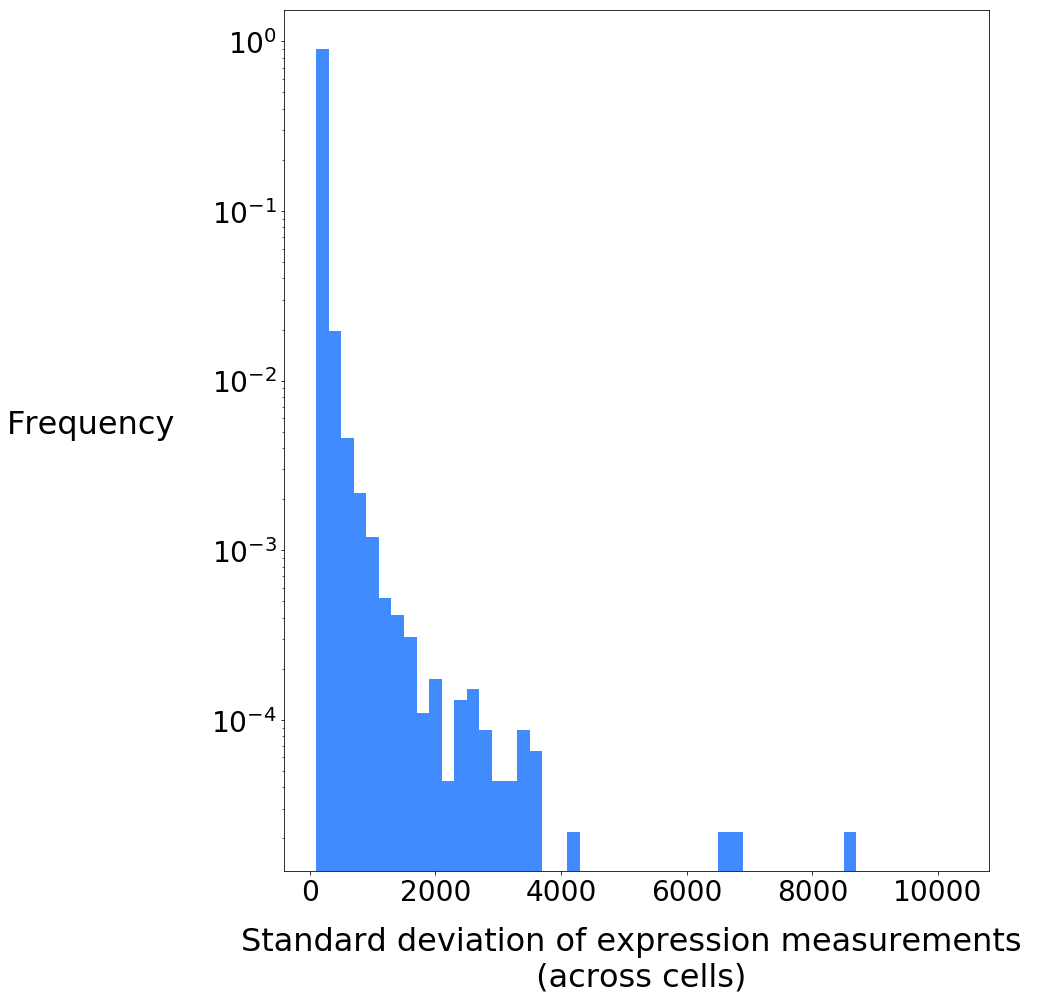

In [31]:
#plot histogram of measurement standard deviations

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [14, 14]

text_size = 32
tick_size = 28

#maxval = np.max(stdevs)
maxval = 10**4
minval = np.min(stdevs[stdevs >= 10**(-6)])
n_bins = 50
bin_width = (maxval - minval)/n_bins

bin_end = maxval + bin_width

h_stdev, bin_edges = np.histogram(stdevs[stdevs >= 10**(-6)], bins = np.arange(0, bin_end, bin_width))
h_stdev = h_stdev/float(len(stdevs))



fig, axes = plt.subplots(1,1)



plt.bar(bin_edges[:-1] + bin_width/2.0, h_stdev, width=bin_width, align='edge', color=[0, 0.4, 1], alpha=0.75, label='transcript standard deviation')
axes.set_yscale('log')
#axes.set_ylim([0, 1])
    
axes.set_xlabel('Standard deviation of expression measurements \n (across cells)', fontsize = text_size, labelpad=20)
axes.set_ylabel('Frequency', fontsize = text_size, rotation='horizontal', labelpad=120)
#plt.legend()
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.tight_layout()
plt.show()

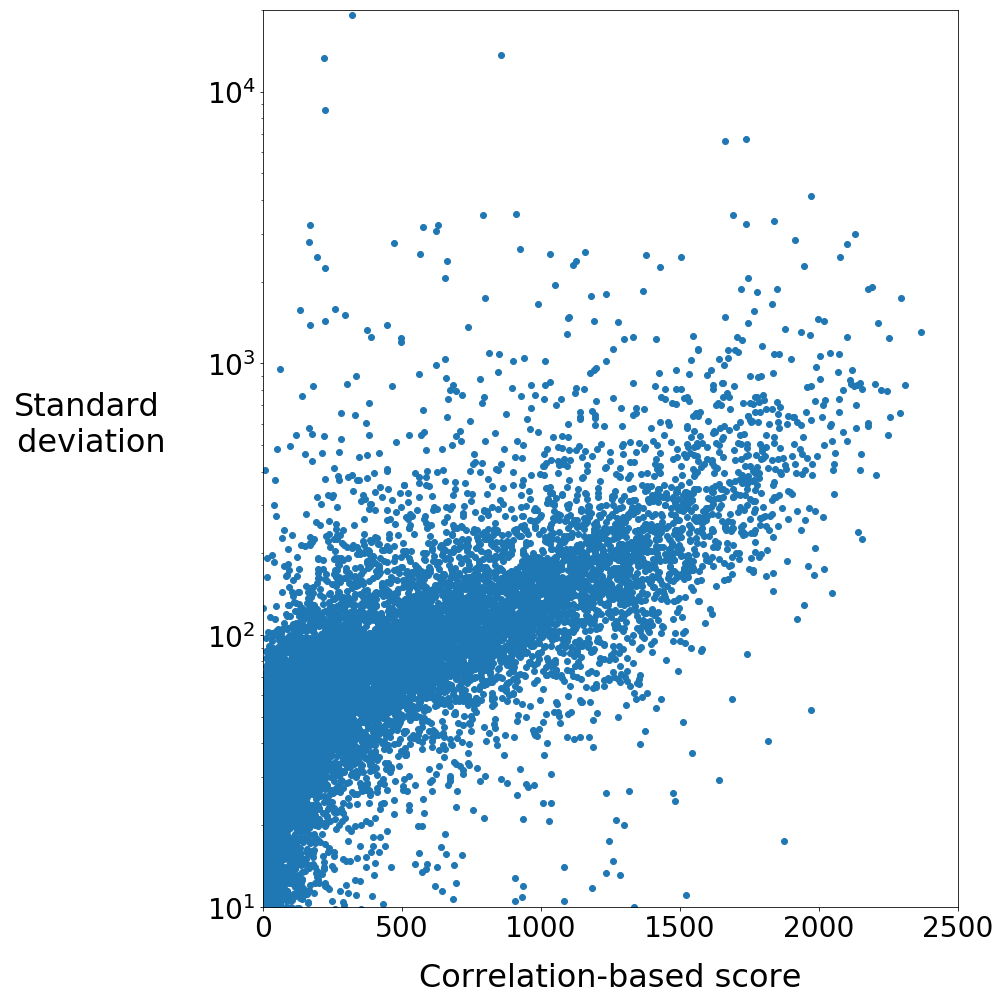

In [77]:
#scatterplot: correlation-based metric vs. stdev

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [14, 14]

text_size = 32
tick_size = 28

fig, axes = plt.subplots(1,1)

plt.scatter(metrics, stdevs)

axes.set_yscale('log')
axes.set_ylim([10**(1), 2*10**(4)])
axes.set_xlim([0, 2500])

axes.set_xlabel('Correlation-based score', fontsize = text_size, labelpad=20)
axes.set_ylabel('Standard\n deviation', fontsize = text_size, rotation='horizontal', labelpad=120)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.tight_layout()
plt.show()

In [9]:
print('Number of transcripts with effectively zero s.d. = %d'%np.sum(stdevs <= 10**(-3)))

Number of transcripts with effectively zero s.d. = 3159


In [26]:
#what is the overlap between different cutoffs?
quantiles = np.arange(0,1,0.025)
overlap_fraction = np.zeros(quantiles.shape)
for i, q in enumerate(quantiles):
    selected_stdev  = stdevs >= np.percentile(stdevs[stdevs >= 10**-6], 100.0*q)
    selected_metric = metrics >= np.percentile(metrics[metrics>=10**(-6)], 100.0*q)
    overlap_fraction[i] = np.sum(selected_stdev*selected_metric)/(0.5*(np.sum(selected_stdev) + np.sum(selected_metric)))

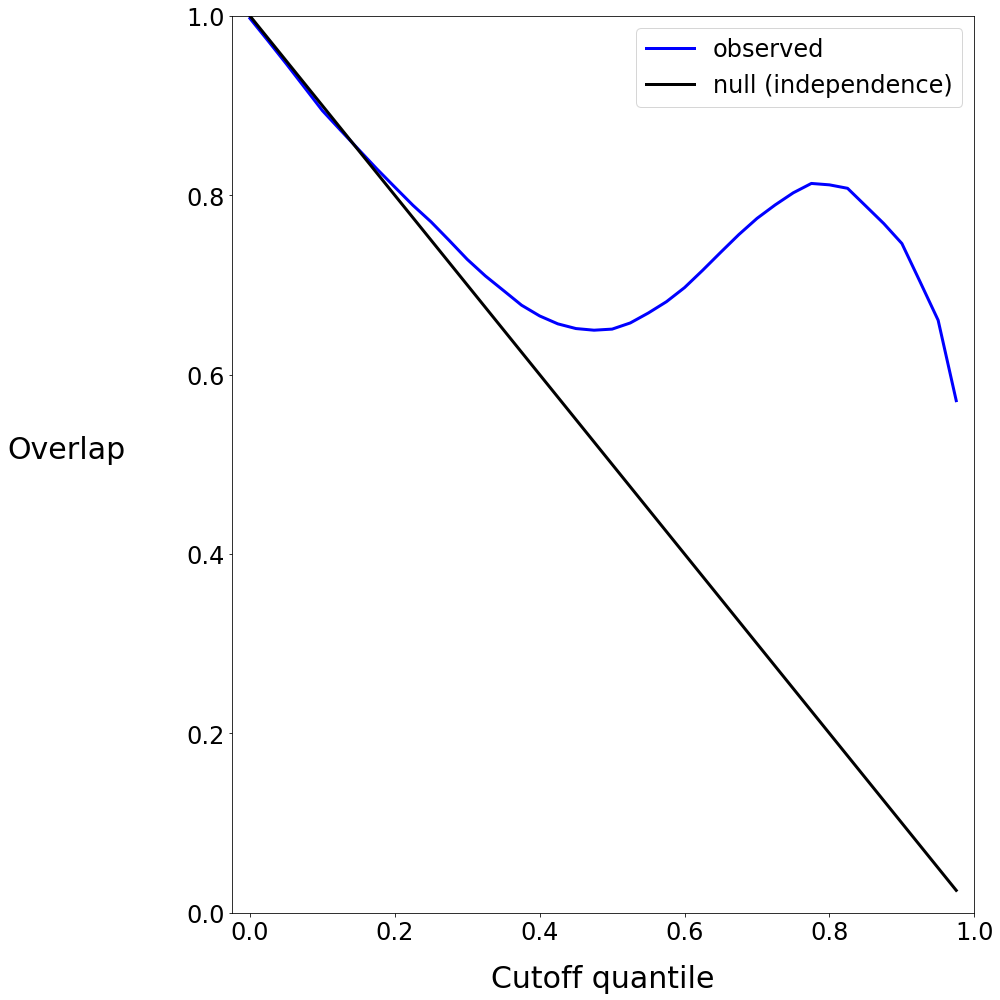

In [37]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [14, 14]

text_size = 30
tick_size = 24

fig, axes = plt.subplots(1,1)

plt.plot(quantiles, overlap_fraction, label='observed', linewidth=3, color=[0,0,1])
plt.plot(quantiles, 1-quantiles, label='null (independence)', linewidth=3, color=[0,0,0])

axes.set_ylim([0, 1])

axes.set_xlabel('Cutoff quantile', fontsize = text_size, labelpad=20)
axes.set_ylabel('Overlap', fontsize = text_size, rotation='horizontal', labelpad=120)

plt.xlim([-0.025, quantiles[-1] + 0.025])
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

plt.legend(fontsize=24)

plt.tight_layout()

plt.show()

In [68]:
#parameters for this run of incremental PCA
p = dict()
p['whiten'] = True
p['batch_size'] = 2000
p['n_components'] = 1000
p['cutoff_quantile'] = 0.0
p['cutoff_factor'] = 'corr_metric'



In [69]:
from sklearn.decomposition import IncrementalPCA
import time

#compute incPCA

#prepare data

if(p['cutoff_factor']=='stdev'):

    p['cutoff_absolute'] = np.percentile(stdevs[stdevs > 10**(-6)], p['cutoff_quantile']*100.0)

    X = np.copy(genedata.iloc[:,stdevs >= p['cutoff_absolute']].values)
    
elif(p['cutoff_factor']=='corr_metric'):

    p['cutoff_absolute'] = np.percentile(metrics[metrics > 0], p['cutoff_quantile']*100.0)

    X = np.copy(genedata.iloc[:,metrics >= p['cutoff_absolute']].values)

print('Dimensionality = %d'%X.shape[1])

if(p['whiten']):
    X = X/np.tile(np.std(X, axis=0)[np.newaxis,:], (X.shape[0], 1))
    print('whitened data (normalized columns, i.e. genes)')


IncPCA = IncrementalPCA(n_components=p['n_components'], whiten=False, copy=True, batch_size=p['batch_size'])
#don't use the PCA whiten option because it doesn't actually do what is normally considered 'whitening'

t0 = time.time()
IncPCA.fit(X)
t_elapsed = time.time() - t0
print('Fit incremental PCA')
print('%d components'%p['n_components'])
print('%d batch_size'%p['batch_size'])
print('Elapsed time was %.1f min'%(t_elapsed/60.0))

Dimensionality = 42484
whitened data (normalized columns, i.e. genes)
Fit incremental PCA
1000 components
2000 batch_size
Elapsed time was 11.1 min


In [70]:
#save incPCA

import pickle

IncPCA_save = dict()
IncPCA_save['IncPCA'] = IncPCA
IncPCA_save['whiten'] = p['whiten']
IncPCA_save['std_cutoff_absolute'] = p['cutoff_absolute']
IncPCA_save['std_cutoff_quantile'] = p['cutoff_quantile']
IncPCA_save['dimensionality'] = X.shape[1]
IncPCA_save['n_cells'] = X.shape[0]
IncPCA_save['batch_size'] = p['batch_size']
IncPCA_save['n_components'] = p['n_components']

save_path = '/Users/cstoneki/Documents/data/gene_expression/tasic_vis_alm_2018/outputs/IncPCA_only_neur_metric_cutoff/'

pickle.dump(IncPCA_save, open(save_path + 'IncPCA_08.pickle', 'wb'))

In [99]:
#description of PCA
def get_incPCA_description(d):
    return 'cutoff = %.2f'%d['std_cutoff_quantile'] + ' | normalized'*(d['whiten'])

In [3]:
#summary plot - all eigenvalue spectra
from os import listdir
from os.path import isfile, join
import re
import pickle



data_path = '/Users/cstoneki/Documents/data/gene_expression/tasic_vis_alm_2018/outputs/IncPCA_only_neur'

pickle_files = [join(data_path, f) for f in listdir(data_path) if isfile(join(data_path, f)) and re.search('.pickle$', f)]

IncPCA_dicts = [pickle.load(open(pf, 'rb')) for pf in pickle_files]

In [64]:
plot_key = [{'std_cutoff_quantile':0, 'whiten':True}, {'std_cutoff_quantile':0.25, 'whiten':True},
            #{'std_cutoff_quantile':0.33, 'whiten':True},
                {'std_cutoff_quantile':0.5, 'whiten':True}, {'std_cutoff_quantile':0.75, 'whiten':True}]

#plot_key = [{'std_cutoff_quantile':0.75, 'whiten':True}, {'std_cutoff_quantile':0.75, 'whiten':False}]

#plot_key = [{'std_cutoff_quantile':0.25, 'whiten':True}, {'std_cutoff_quantile':0.0, 'whiten':False}, {'std_cutoff_quantile':0.25, 'whiten':True}, {'std_cutoff_quantile':0.25, 'whiten':False}]

In [4]:


def dict_match(d_small, d_large):
    for key, value in d_small.items():
        if(key not in d_large or not (d_large[key]==value)):
            return False
    return True
            

            
def retrieve(dict_list, key):
    for d in dict_list:
        if(dict_match(key,d)):
            return d

In [72]:
objects_to_plot = []
for k in plot_key:
    for d in IncPCA_dicts:
        if(dict_match(k, d)):
            objects_to_plot.append(d)
            break

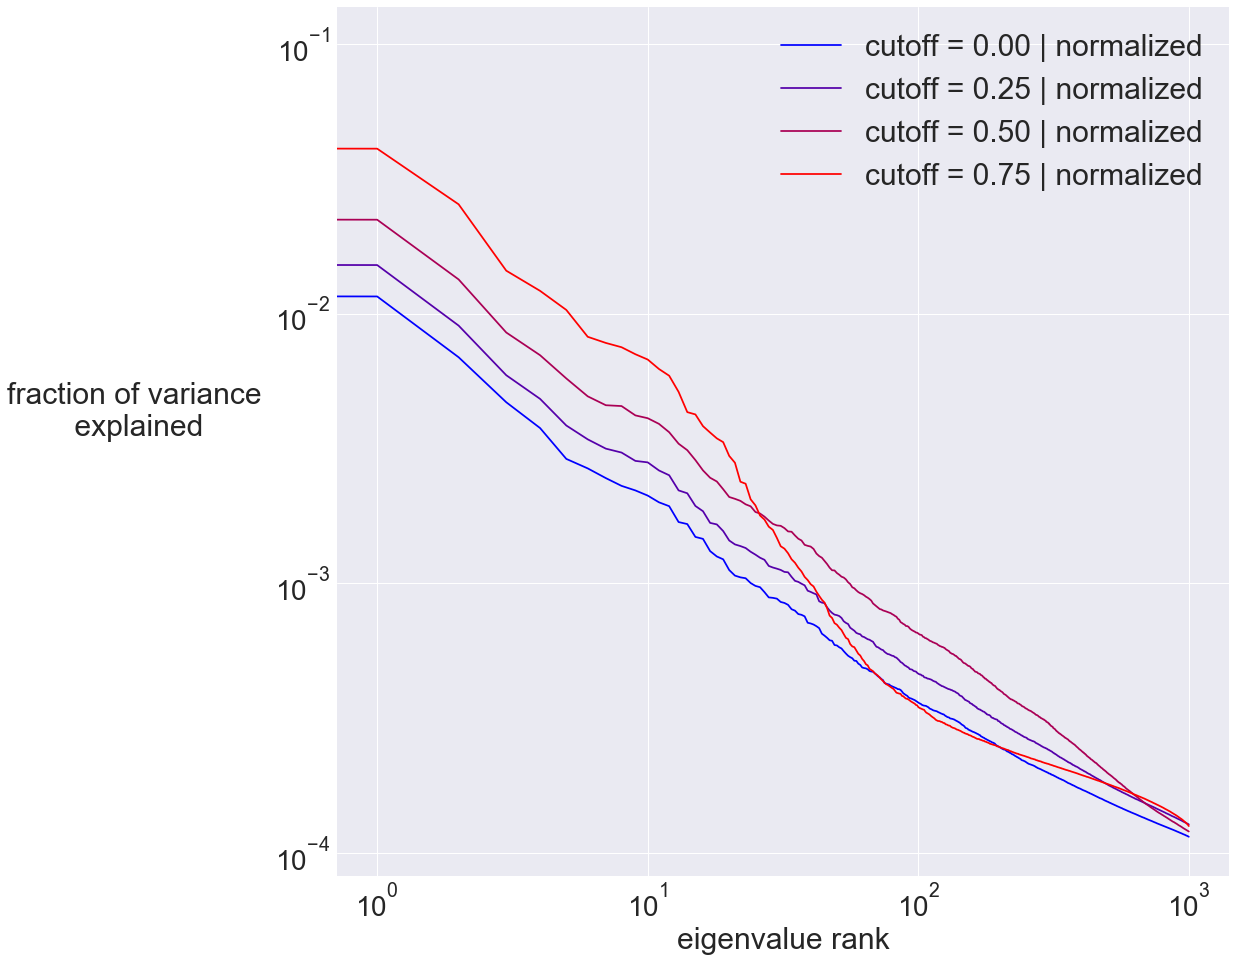

In [73]:
#plot eigenspectra
import matplotlib.pyplot as plt
import seaborn
seaborn.set(font_scale=2.0)
text_size = 30
tick_size = 28

plt.rcParams["figure.figsize"] = [16,16]
fig, ax = plt.subplots()

color_1 = np.array([0, 0, 1])
color_2 = np.array([1, 0, 0])

for k, d in enumerate(objects_to_plot):
    eigenvalues = d['IncPCA'].explained_variance_ratio_
    x_to_plot = np.arange(0, len(eigenvalues))
    y_to_plot = eigenvalues
    
    color_k = color_1 + (color_2 - color_1)* k/float(max(len(objects_to_plot) - 1, 1))
    
    plt.plot(x_to_plot, y_to_plot, color=color_k, label=get_incPCA_description(d))
    
plt.legend(prop={'size': text_size})
ax.set_yscale('log')
ax.set_xscale('log')
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

plt.xlabel('eigenvalue rank', fontsize=text_size)
plt.ylabel('fraction of variance\n explained', fontsize=text_size, rotation='horizontal', labelpad=140)

    
plt.show()


In [81]:
#plot mapping between stdev quantile and contribution to quantile of principal components
#principal components have unit norm
#take sum of coefficients within group of interest, squared
n_components = 200
n_quantiles = 20

comps_per_block = float(n_components)/n_quantiles

qq_matrix = np.zeros([n_quantiles, n_quantiles])
#rows: different PC blocks
#columns: different stdev blocks

qq_pc_sum = np.zeros(n_quantiles)

IncPCA_full = retrieve(IncPCA_dicts, {'whiten':True, 'std_cutoff_quantile':cutoff_quantile})

stdev_quantiles = np.linspace(0, 1, n_quantiles+1)[1:]
pc_index_blocks = np.reshape(np.arange(n_components), [n_quantiles, -1])
#each row is a separate block

pc_mat = IncPCA_full['IncPCA'].components_ 
#each row is a principal component

coord_subset_size = np.zeros(n_quantiles)

for i in range(n_quantiles):
    pc_block = pc_mat[pc_index_blocks[i,:],:]
    qq_pc_sum[i] = np.sum(np.square(pc_block))
    for j in range(n_quantiles):
        if(j==0):
            q = np.percentile(stdevs_X, stdev_quantiles[j]*100.0)
            coord_subset= stdevs_X <= q
        else:
            q1 = np.percentile(stdevs_X, stdev_quantiles[j-1]*100.0)
            q2 = np.percentile(stdevs_X, stdev_quantiles[j]*100.0)
            coord_subset= np.logical_and(q1 <= stdevs_X, stdevs_X <= q2)
            
        coord_subset_size[j] = np.sum(1.0*coord_subset)
        
        contribution = np.sum(np.square(pc_block[:, coord_subset]))/comps_per_block
        
        qq_matrix[i,j] = contribution
        
        





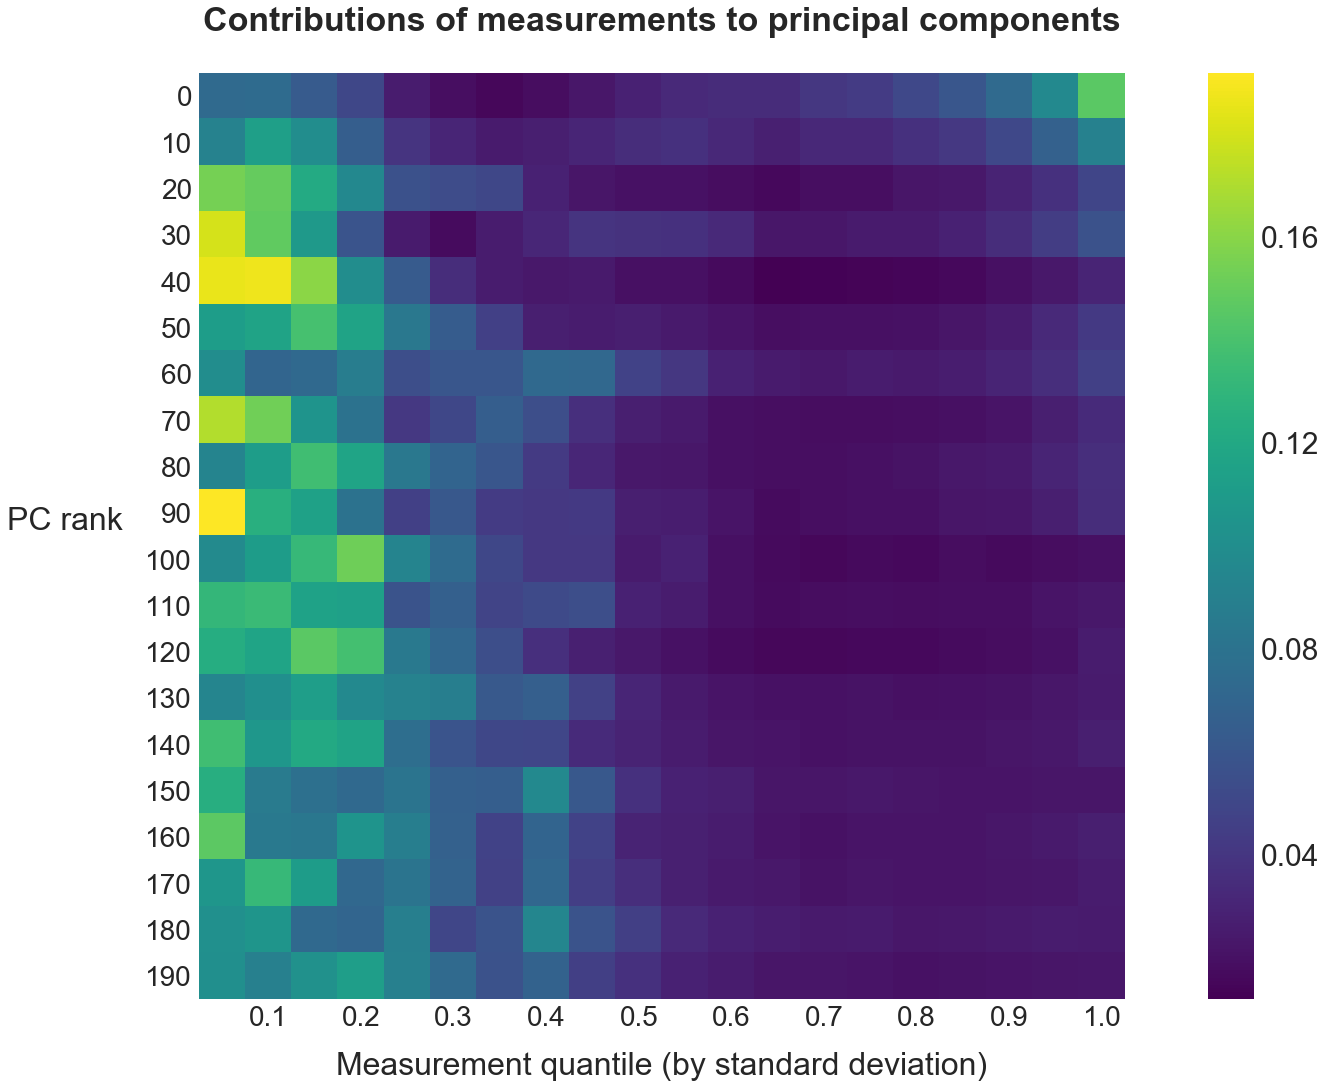

In [82]:
#heatmap of qq_matrix
import seaborn


seaborn.set(font_scale=3.0)
text_size = 32
tick_size = 28

plt.rcParams["figure.figsize"] = [24,16]
ax = plt.gca()

im = seaborn.heatmap(qq_matrix, yticklabels = pc_index_blocks[:,0], xticklabels=stdev_quantiles , cmap = plt.get_cmap('viridis'), square = True)

plt.xticks(np.arange(1.5,20, 2), np.arange(0.1,1 + 10**(-6), 0.1), rotation='horizontal', fontsize=tick_size)
#plt.yticks(np.arange(0.5,corr_ordered.shape[0], 1), row_indices)
plt.yticks(fontsize=tick_size, rotation='horizontal')


ax.set_title("Contributions of measurements to principal components\n", fontsize = 34, fontweight='bold')
plt.xlabel('Measurement quantile (by standard deviation)', fontsize=text_size, labelpad=20)
plt.ylabel('PC rank', rotation='horizontal', labelpad=80, fontsize=text_size)
plt.tight_layout()
plt.show()

In [ ]:
#reduce dimension using PCA with parameters of choice, and save

In [10]:
pca_key = {'std_cutoff_quantile':0.0, 'whiten':True}

cutoff_on_stdev = True

pca = retrieve(IncPCA_dicts, pca_key)

In [12]:
if(cutoff_on_stdev==True):

    X = np.copy(genedata.iloc[:,stdevs >= pca['std_cutoff_absolute']].values)
else:

    X = np.copy(genedata.iloc[:,metrics >= pca['std_cutoff_absolute']].values)

stdevs_X = np.std(X, axis=0) 

if(pca_key['whiten']):
    X = X/np.tile(np.std(X, axis=0)[np.newaxis,:], (X.shape[0], 1))
    print('whitened data (normalized columns, i.e. genes)')

whitened data (normalized columns, i.e. genes)


In [13]:
dim = 200
#reduced_basis = np.transpose(pca['IncPCA'].components_[0:dim,:])
reduced_basis = np.transpose(pca['IncPCA'].components_)
#columns of this are first PCs
X_reduced = np.matmul(X, reduced_basis)

In [14]:
X_reduced_df = pd.DataFrame(data=X_reduced, dtype='float64')
X_reduced_df.to_csv('/Users/cstoneki/Documents/data/gene_expression/tasic_vis_alm_2018/X_reduced_for_classifier.csv' )

In [3]:
#check for possible artefacts - correlations between PC-transformed data and metadata
#issue: probably too many FACS containers to detect any effect
#same for RNA amplification set, library prep set, seq name, seq tube, seq batch
import datetime

systematic = pd.DataFrame()
systematic['sex'] = metadata['sex']=='M'
systematic['age']      = metadata['age_days']
systematic['facs_date'] = [(datetime.datetime.strptime(s, "%m/%d/%Y") - datetime.datetime(2010, 1, 1)).total_seconds() for s in metadata['facs_date']]

systematic['total_reads'] = metadata['total_reads']
systematic['exon_reads'] = metadata['percent_exon_reads']
systematic['intron_reads'] = metadata['percent_intron_reads']
systematic['intergenic_reads'] = metadata['percent_intergenic_reads']
systematic['rrna_reads'] = metadata['percent_rrna_reads']
systematic['mt_exon_reads'] = metadata['percent_mt_exon_reads']
systematic['synth_reads'] = metadata['percent_synth_reads']
systematic['unique_reads'] = metadata['percent_reads_unique']
systematic['ecoli_reads'] = metadata['percent_ecoli_reads']
systematic['aligned_reads'] = metadata['percent_aligned_reads_total']
systematic['complexity_cg'] = metadata['complexity_cg']
systematic['cpm_criterion'] = metadata['genes_detected_cpm_criterion']
systematic['fpkm_criterion'] = metadata['genes_detected_fpkm_criterion']
systematic['tdt_cpm'] = metadata['tdt_cpm']
systematic['gfp_cpm'] = metadata['gfp_cpm']
systematic['lib_prep_avg_size'] = metadata['library_prep_avg_size_bp']

#clean
systematic['lib_prep_avg_size'][np.isnan(systematic['lib_prep_avg_size'])] = np.nanmean(systematic['lib_prep_avg_size'])

NameError: name 'metadata' is not defined

In [50]:
systematic_correlations = np.zeros([len(systematic.columns), X_reduced.shape[1]])
#systematic factors x principal components

row_labels = []

X_for_corr = np.transpose(X_reduced)
#rows now correspond to principal components
X_for_corr = X_for_corr - np.tile(np.mean(X_for_corr, axis=1)[:, np.newaxis], [1, X_for_corr.shape[1]])
X_for_corr = X_for_corr/np.tile(np.std(X_for_corr, axis=1)[:, np.newaxis], [1, X_for_corr.shape[1]])                                  

for k, col in enumerate(systematic.columns):
    f = systematic[col].values
    f = (f - np.mean(f))/np.std(f)
    c = np.matmul(X_for_corr, f)/float(len(f))
    systematic_correlations[k, :] = c
    row_labels.append(col)


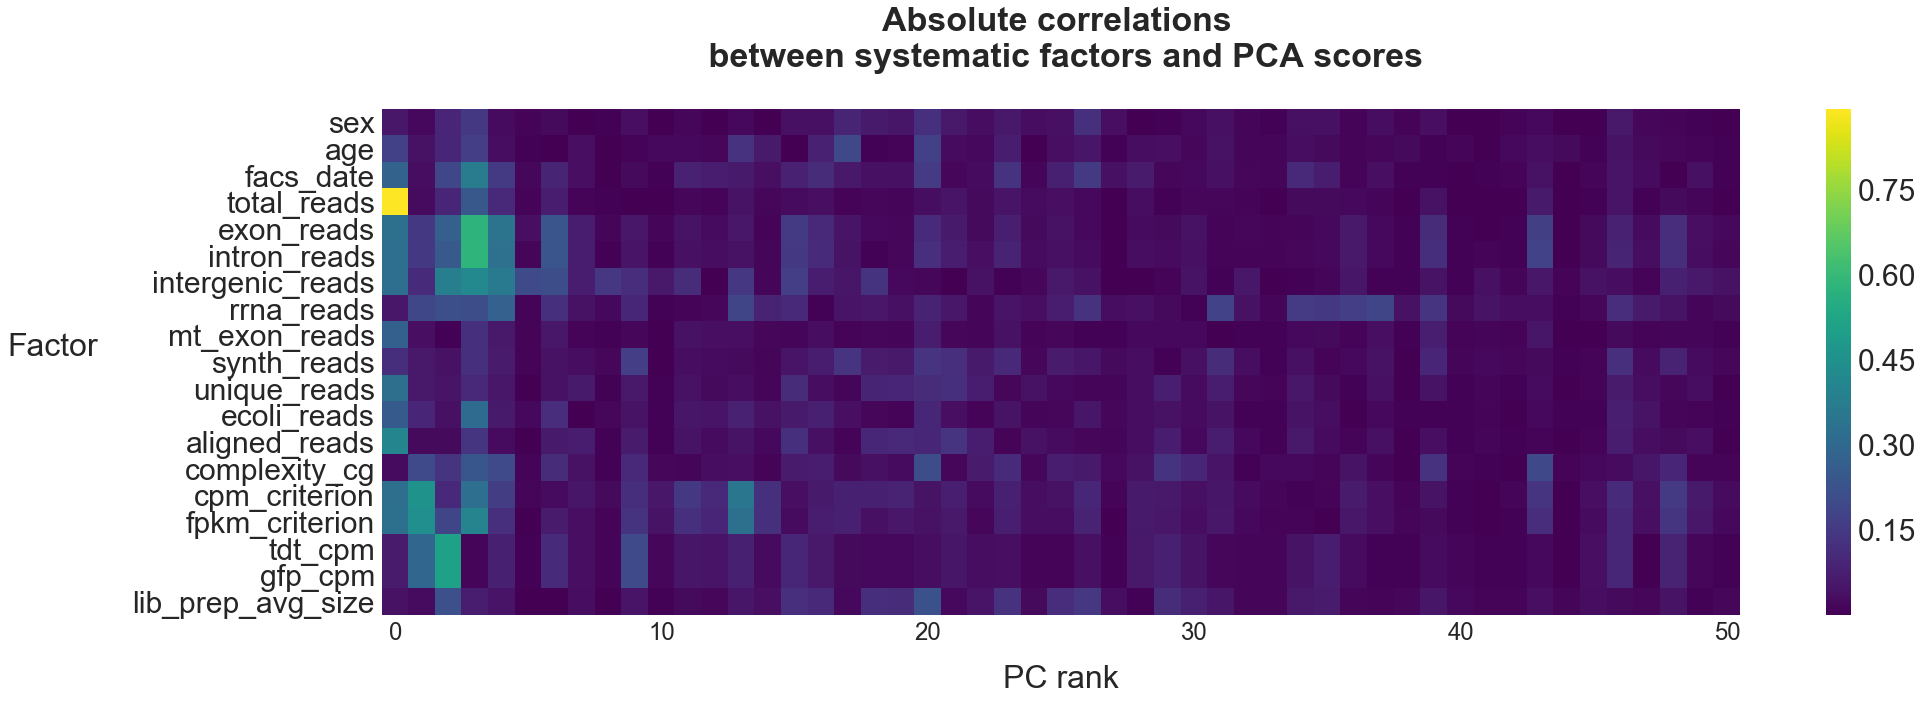

In [51]:
import seaborn

pcs_to_plot = 51

seaborn.set(font_scale=3)
text_size = 32
tick_size = 28

plt.rcParams["figure.figsize"] = [30,10]
ax = plt.gca()

im = seaborn.heatmap(np.abs(systematic_correlations[:,0:pcs_to_plot]), yticklabels = row_labels, cmap = plt.get_cmap('viridis'), square = True)

#plt.xticks(np.arange(1.5,20, 2), np.arange(0.1,1 + 10**(-6), 0.1), rotation='horizontal', fontsize=tick_size)
#plt.yticks(np.arange(0.5,corr_ordered.shape[0], 1), row_indices)
plt.xticks(np.arange(0.5, pcs_to_plot, 10), np.arange(0, pcs_to_plot, 10), fontsize=24, rotation='horizontal')
plt.yticks(fontsize=30, rotation='horizontal')


ax.set_title("Absolute correlations \n between systematic factors and PCA scores\n", fontsize = 34, fontweight='bold')
plt.xlabel('PC rank', fontsize=text_size, labelpad=20)
plt.ylabel('Factor', rotation='horizontal', labelpad=80, fontsize=text_size)
plt.tight_layout()
plt.show()

### Clustering

In [2]:
data_dir = '/Users/cstoneki/Documents/data/gene_expression/tasic_vis_alm_2018/'
X_reduced_filename = 'X_reduced_only_neurons_050cutoff.csv'
X_reduced = pd.read_csv(data_dir+X_reduced_filename, index_col=0, dtype='float64').values

In [52]:
#remove columns that are highly correlated with systematic factors
abs_corr_cutoff = 0.7
abs_corr = np.abs(systematic_correlations)
keep = np.max(abs_corr, axis=0) < abs_corr_cutoff
print("Number of columns that will be discarded = %d"%np.sum(np.logical_not(keep)))
X_reduced_filtered = X_reduced[:,keep]

Number of columns that will be discarded = 1


In [16]:
X_reduced.shape

(22439, 200)

In [20]:
data_dir = '/Users/cstoneki/Documents/data/gene_expression/tasic_vis_alm_2018/'
metadata = pd.read_csv(data_dir + 'tasic_2018_metadata.csv', index_col=0, low_memory=False)
only_neurons=True
if(only_neurons):
    neuron_indices = np.logical_or(metadata['class']=='Glutamatergic', metadata['class']=='GABAergic')
    metadata = metadata.loc[neuron_indices.values,:]

In [14]:
print('Number of clusters in Tasic et al. clustering = %3d'%len(np.unique(metadata['cluster'])))

Number of clusters in Tasic et al. clustering = 117


In [ ]:
#plot spectral embedding

from sklearn.manifold import SpectralEmbedding

embedding = SpectralEmbedding(n_components=2)
X_embedded = embedding.fit_transform(X)

In [ ]:
#plot spectral embedding
#use multiple colors
plt.rcParams["figure.figsize"] = [16,16]

glut_alm = np.logical_and(metadata['class']=='Glutamatergic', metadata['brain_region']=='ALM')
glut_vis = np.logical_and(metadata['class']=='Glutamatergic', metadata['brain_region']=='VISp')
gaba_alm = np.logical_and(metadata['class']=='GABAergic', metadata['brain_region']=='ALM')
gaba_vis = np.logical_and(metadata['class']=='GABAergic', metadata['brain_region']=='VISp')

plt.scatter(X_embedded[glut_alm,0], X_embedded[glut_alm,1], color=[1,0,0.5], marker='.', label='Glutamatergic | ALM')
plt.scatter(X_embedded[glut_vis,0], X_embedded[glut_vis,1], color=[1,0,0.5], marker='+', label='Glutamatergic | VIS')
plt.scatter(X_embedded[gaba_alm,0], X_embedded[gaba_alm,1], color=[0,0.5,1], marker='.', label='GABAergic | ALM')
plt.scatter(X_embedded[gaba_vis,0], X_embedded[gaba_vis,1], color=[0,0.5,1], marker='+', label='GABAergic | VIS')

plt.legend()

plt.show()

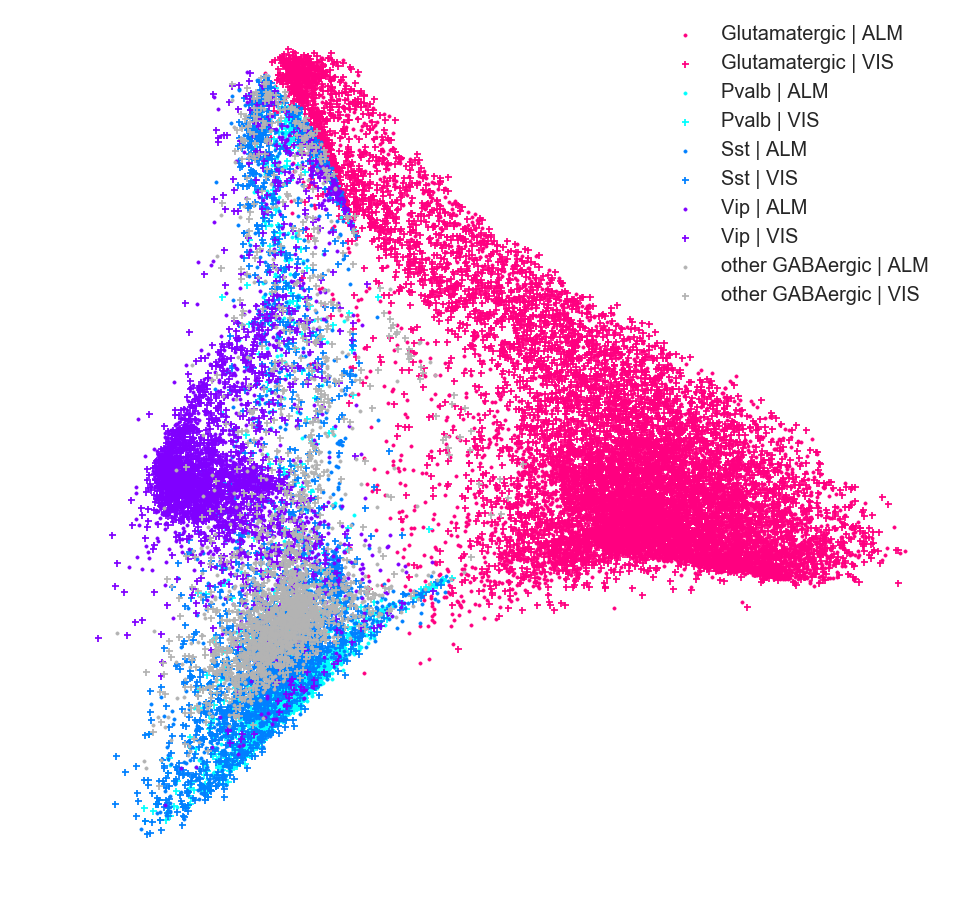

In [54]:
seaborn.set(font_scale=2.0)
text_size = 20

gabaergic_clusters = np.unique(metadata[metadata['class']=='GABAergic']['cluster'])

pvalb_clusters = [c for c in gabaergic_clusters if 'Pvalb' in c]
sst_clusters = [c for c in gabaergic_clusters if 'Sst' in c]
vip_clusters = [c for c in gabaergic_clusters if 'Vip' in c]
other_clusters = [c for c in gabaergic_clusters if not(c in pvalb_clusters or c in sst_clusters or c in vip_clusters)]

pvalb_cells = [ metadata['cluster'].values[i] in pvalb_clusters for i in range(metadata.shape[0])]
sst_cells = [metadata['cluster'].values[i] in sst_clusters for i in range(metadata.shape[0])]
vip_cells = [metadata['cluster'].values[i] in vip_clusters for i in range(metadata.shape[0]) ]
other_cells = [metadata['cluster'].values[i] in other_clusters for i in range(metadata.shape[0])]

pvalb_alm = np.logical_and(pvalb_cells, metadata['brain_region']=='ALM')
pvalb_vis = np.logical_and(pvalb_cells, metadata['brain_region']=='VISp')
sst_alm = np.logical_and(sst_cells, metadata['brain_region']=='ALM')
sst_vis = np.logical_and(sst_cells, metadata['brain_region']=='VISp')
vip_alm = np.logical_and(vip_cells, metadata['brain_region']=='ALM')
vip_vis = np.logical_and(vip_cells, metadata['brain_region']=='VISp')
other_alm = np.logical_and(other_cells, metadata['brain_region']=='ALM')
other_vis = np.logical_and(other_cells, metadata['brain_region']=='VISp')
glut_alm = np.logical_and(metadata['class']=='Glutamatergic', metadata['brain_region']=='ALM')
glut_vis = np.logical_and(metadata['class']=='Glutamatergic', metadata['brain_region']=='VISp')


plt.scatter(X_embedded[glut_alm,0], X_embedded[glut_alm,1], color=[1,0,0.5], marker='.', label='Glutamatergic | ALM')
plt.scatter(X_embedded[glut_vis,0], X_embedded[glut_vis,1], color=[1,0,0.5], marker='+', label='Glutamatergic | VIS')

plt.scatter(X_embedded[pvalb_alm,0], X_embedded[pvalb_alm,1], color=[0,1,1], marker='.', label='Pvalb | ALM')
plt.scatter(X_embedded[pvalb_vis,0], X_embedded[pvalb_vis,1], color=[0,1,1], marker='+', label='Pvalb | VIS')

plt.scatter(X_embedded[sst_alm,0], X_embedded[sst_alm,1], color=[0,0.5,1], marker='.', label='Sst | ALM')
plt.scatter(X_embedded[sst_vis,0], X_embedded[sst_vis,1], color=[0,0.5,1], marker='+', label='Sst | VIS')

plt.scatter(X_embedded[vip_alm,0], X_embedded[vip_alm,1], color=[0.5,0,1], marker='.', label='Vip | ALM')
plt.scatter(X_embedded[vip_vis,0], X_embedded[vip_vis,1], color=[0.5,0,1], marker='+', label='Vip | VIS')

plt.scatter(X_embedded[other_alm,0], X_embedded[other_alm,1], color=[0.7,0.7,0.7], marker='.', label='other GABAergic | ALM')
plt.scatter(X_embedded[other_vis,0], X_embedded[other_vis,1], color=[0.7,0.7,0.7], marker='+', label='other GABAergic | VIS')

plt.axis('off')

plt.legend(fontsize=text_size)
plt.show()



In [56]:
#compute histogram of distances

distance_values = np.reshape(1 - C_reduced_data, -1)
bin_width = 0.05

h_dist, bin_edges = np.histogram(distance_values, bins = np.arange(0, 1.001, bin_width))
h_dist = h_dist/float(np.sum(h_dist))


In [ ]:
#plot histogram of distances
import matplotlib.pyplot as plt
import seaborn

seaborn.set(font_scale=1.5)

plt.rcParams["figure.figsize"] = [9,7]
plt.bar(bin_edges[:-1], h_dist, width=bin_width, align='edge', color=[0, 0.2, 1], alpha=0.75, label='distances')

plt.xlabel('Distance (= 1 - correlation)', fontsize=15)
plt.ylabel('Count (normalized)',fontsize=15)
plt.xlim([0, 1])
plt.title('Distribution of distance values\n (after dimensionality reduction) \n\n', fontsize=17)

#plt.legend()
        
plt.tight_layout()
plt.show()

In [23]:
def plot_area_specificity(clustering):
    import matplotlib.pyplot as plt
    import seaborn

    normalize = False

    plt.rcParams["figure.figsize"] = [16,6]

    seaborn.set(font_scale=1.5)
    text_size = 20
    tick_size = 8

    new_cluster_labels = [i for i in np.unique(clustering) if not i==-1]

    #plot noise separately
    have_noise = np.sum(clustering==-1) > 0

    if(have_noise):
        new_cluster_labels = np.append(new_cluster_labels, -1)
        
    tasic_cluster_labels = np.unique(metadata['cluster'])
        
    #determine fraction of glutamatergic cells for each cluster
    glut_fraction_new = np.zeros(len(new_cluster_labels))
    vis_fraction_new = np.zeros(len(new_cluster_labels))
    glut_fraction_tasic = np.zeros(len(tasic_cluster_labels))
    vis_fraction_tasic = np.zeros(len(tasic_cluster_labels))
    
    for k,i in enumerate(new_cluster_labels):
        metadata_this_cluster = metadata.loc[clustering==i,:]
        glut_fraction_new[k] = np.sum(metadata_this_cluster['class']=='Glutamatergic')/float(metadata_this_cluster.shape[0])
        vis_fraction_new[k] = np.sum(metadata_this_cluster['brain_region']=='VISp')/float(metadata_this_cluster.shape[0])
    for k,i in enumerate(tasic_cluster_labels):
        metadata_this_cluster = metadata.loc[metadata['cluster']==i,:]
        glut_fraction_tasic[k] = np.sum(metadata_this_cluster['class']=='Glutamatergic')/float(metadata_this_cluster.shape[0])
        vis_fraction_tasic[k] = np.sum(metadata_this_cluster['brain_region']=='VISp')/float(metadata_this_cluster.shape[0])
    
    #print(glut_fraction_new)
    
    #compute histograms
    bin_width = 0.05

    h_glut_new, bin_edges = np.histogram(vis_fraction_new[glut_fraction_new >= 0.8], bins = np.arange(0, 1.001, bin_width))
    h_glut_new = h_glut_new/float(np.sum(h_glut_new))
    
    h_gaba_new, bin_edges = np.histogram(vis_fraction_new[glut_fraction_new < 0.2], bins = np.arange(0, 1.001, bin_width))
    h_gaba_new = h_gaba_new/float(np.sum(h_gaba_new))

    h_glut_tasic, bin_edges = np.histogram(vis_fraction_tasic[glut_fraction_tasic >= 0.8], bins = np.arange(0, 1.001, bin_width))
    h_glut_tasic = h_glut_tasic/float(np.sum(h_glut_tasic))
    
    h_gaba_tasic, bin_edges = np.histogram(vis_fraction_tasic[glut_fraction_tasic < 0.8], bins = np.arange(0, 1.001, bin_width))
    h_gaba_tasic = h_gaba_tasic/float(np.sum(h_gaba_tasic))
    
    fig, axes = plt.subplots(nrows = 2, ncols = 2)
    
    plt.rcParams["figure.figsize"] = [9,7]
    
    plt.sca(axes[0, 0])
    plt.bar(bin_edges[:-1], h_glut_tasic, width=bin_width, align='edge', color=[1, 0, 0.5], alpha=0.75, label='Glutamatergic')
    plt.ylim([0, 0.5])
    #plt.xticks([0, 1], ['ALM', 'VISp'])
    plt.text(0.35,0.6,'Tasic et al.')
    plt.text(-0.5, 0.2, 'Glutamatergic') 
    
    
    plt.sca(axes[1,0])
    plt.bar(bin_edges[:-1], h_gaba_tasic, width=bin_width, align='edge', color=[0.3,0,1], alpha=0.75, label='GABAergic')
    plt.ylim([0, 0.5])
    plt.text(-0.5, 0.2, 'GABAergic')
    
    plt.sca(axes[0,1])
    plt.bar(bin_edges[:-1], h_glut_new, width=bin_width, align='edge', color=[1, 0, 0.5], alpha=0.75, label='Glutamatergic')
    plt.ylim([0, 0.5])
    plt.text(0.35,0.6,'Current work')
    
    
    plt.sca(axes[1,1])
    plt.bar(bin_edges[:-1], h_gaba_new, width=bin_width, align='edge', color=[0.3,0,1], alpha=0.75, label='GABAergic')
    plt.ylim([0, 0.5])
        
    
    plt.show()
    

In [12]:
from itertools import compress
import matplotlib.pyplot as plt
import seaborn

def plot_single_piechart(axis, cluster_metadata):

    n_glut = np.sum(cluster_metadata['class']=='Glutamatergic')
    n_GABA = np.sum(cluster_metadata['class']=='GABAergic')
    n_endo = np.sum(cluster_metadata['class']=='Endothelial')
    n_nonr = np.sum(cluster_metadata['class']=='Non-Neuronal')
    n_other = cluster_metadata.shape[0] - (n_glut + n_GABA + n_endo + n_nonr)
    n_total = cluster_metadata.shape[0]
    
    sizes = np.array([n_glut/float(n_total)*100, n_GABA/float(n_total)*100, 
             n_endo/float(n_total)*100, n_nonr/float(n_total)*100, n_other/float(n_total)*100])
    
    labels = ['Glut', 'GABA', 'Endo', 'NonNeur', 'Other']
    
    colors = [[1,0,0.5], [0,0.5,1], [0.7,0.2,0.0], [0,0.8,0.4], [0.7, 0.7, 0.7]]
    
    explode = (0,0,0,0,0)
    
    cutoff = 10**(-6)
    
    unary = np.sum(sizes > cutoff)==1
    
    take = sizes > cutoff
    
    labels = list(compress(labels, take))
    colors = list(compress(colors, take))
    explode = list(compress(colors, take))
    sizes   = list(compress(sizes, take))
    
    if(unary):
        sizes = [sizes]
        
    axis.pie(sizes,labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=90)
    axis.axis('equal') 
    axis.text(-0.2,1.1,'N=%d'%n_total)

def plot_piecharts(clustering):

    plt.rcParams["figure.figsize"] = [24,24]

    cluster_labels = [i for i in np.unique(clustering) if not i==-1]

    n_clust = len(cluster_labels)

    #plot noise separately
    have_noise = np.sum(clustering==-1) > 0

    score_neur = np.zeros(len(cluster_labels))
    score_glut = np.zeros(len(cluster_labels))

    for k, i in enumerate(cluster_labels):
        cluster_indices = clustering==i
        cluster_metadata = metadata.iloc[cluster_indices]

        n_glut = np.sum(cluster_metadata['class']=='Glutamatergic')
        n_GABA = np.sum(cluster_metadata['class']=='GABAergic')
        n_endo = np.sum(cluster_metadata['class']=='Endothelial')
        n_nonr = np.sum(cluster_metadata['class']=='Non-Neuronal')
        n_other = cluster_metadata.shape[0] - (n_glut + n_GABA + n_endo + n_nonr)
        n_total = cluster_metadata.shape[0]
    
        score_neur[k] = (n_glut + n_GABA)/float(n_total)
        score_glut[k] = (n_glut)/float(n_glut + n_GABA) if (n_glut + n_GABA > 0) else 0
    
    order_neur = np.argsort(score_neur)[::-1]
    #most neuronal first

    n_rows = int(np.floor(np.sqrt(n_clust)))
    n_cols = int(np.ceil(n_clust/float(n_rows)))

    fig, axes = plt.subplots(nrows = n_rows + 1, ncols = n_cols)

    used = np.zeros(axes.shape, dtype=bool)

    for i in range(n_clust):
        c = i/n_rows
        r = i - n_rows*c
        index = cluster_labels[order_neur[i]]
        cluster_metadata = metadata.iloc[clustering==index]
        plot_single_piechart(axes[r,c], cluster_metadata)

        used[r,c] = True
    
    #now plot noise set
    if(have_noise):
        noise_metadata = metadata.iloc[clustering==-1]
        plot_single_piechart(axes[n_rows,0], noise_metadata)
        used[n_rows,0] = True
    
    #clean up
    for r in range(axes.shape[0]):
        for c in range(axes.shape[1]):
            if(not used[r,c]):
                axes[r,c].set_axis_off()

    
    plt.show()
    
    

In [24]:
#plot matrix comparing original (Tasic et al. 2018) and new clustering

def plot_breakdown_matrix(clustering, fig_size=(24,6)):

    import matplotlib.pyplot as plt
    import seaborn

    normalize = False

    #plt.rcParams["figure.figsize"] = [24,6]
    plt.figure(figsize = fig_size)

    sep_size = 5

    seaborn.set(font_scale=1.5)
    text_size = 20
    tick_size = 8

    new_cluster_labels = [i for i in np.unique(clustering) if not i==-1]

    #plot noise separately
    have_noise = np.sum(clustering==-1) > 0

    #need to figure out some order on the new cluster labels

    if(have_noise):
        new_cluster_labels = np.append(new_cluster_labels, -1)
    
    
    tasic_cluster_labels_glut = np.unique(metadata.loc[metadata['class']=='Glutamatergic',:]['cluster'])
    tasic_cluster_labels_glut.sort()

    tasic_cluster_labels_gaba = np.unique(metadata.loc[metadata['class']=='GABAergic',:]['cluster'])
    tasic_cluster_labels_gaba.sort()

    tasic_cluster_labels = list(tasic_cluster_labels_glut) + ['']*sep_size + list(tasic_cluster_labels_gaba)


    A = np.zeros([len(new_cluster_labels), len(tasic_cluster_labels)])

    for i, label in enumerate(new_cluster_labels):
        cluster_metadata = metadata.loc[clustering==label,:]
        for j in range(len(tasic_cluster_labels)):
            A[i,j] = np.sum(cluster_metadata['cluster']==tasic_cluster_labels[j])
        
    #normalize - rows sum to 1
    if(normalize):
        A = A/np.tile(np.sum(A, axis=1)[:, np.newaxis], [1, A.shape[1]])


    #turn all zero entries into nan
    #otherwise we can't read the low-valued entries
    A[A==0] = np.nan

    #for j in range(len(tasic_cluster_labels)):
    #    if(tasic_cluster_labels[j]==''):
    #        A[:,j] = np.nan*np.ones(A.shape[0])
        


    yticklabels = ['']*len(new_cluster_labels)
    if(have_noise):
        yticklabels[-1] = 'noise'
    

    ax = plt.gca()
    im = seaborn.heatmap(A, yticklabels = yticklabels, xticklabels=tasic_cluster_labels , cmap = plt.get_cmap('viridis'), square = True)

    plt.xticks(rotation='vertical', fontsize=tick_size)
    #plt.yticks(np.arange(0.5,corr_ordered.shape[0], 1), row_indices)
    plt.yticks(fontsize=tick_size + 4, rotation='horizontal')

    #plt.rcParams['titlepad'] = 50
    #ax.set_title("DBSCAN clusters compared with original clusters\n", fontsize = 15)
    ax.text(20,-5,"Glutamatergic", fontsize = 20)
    ax.text(80,-5,"GABAergic", fontsize = 20)
    plt.tight_layout()
    plt.show()

        

In [ ]:
#DBSCAN
from sklearn.cluster import DBSCAN
import time

dbscan = DBSCAN(eps=0.001, min_samples=1, metric='precomputed', algorithm='auto')
#t0 = time.time()
dbscan = dbscan.fit(1 - C_reduced)
#t_elapsed = time.time() - t0
#print('Ran DBSCAN. Elapsed time is %.2f min'%(t_elapsed/60.0))
clustering = dbscan.labels_
plot_breakdown_matrix(clustering)
n_clust = len(np.unique(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
n_noise = np.sum(dbscan.labels_==-1)
print('Number of clusters is %d'%n_clust)
print('Number of noise points is %d'%n_noise)
print('Total number of points is %d'%len(dbscan.labels_))

In [ ]:
#kmeans
from sklearn.cluster import KMeans
km = KMeans(n_clusters=20, n_init = 10, max_iter=300)
km = km.fit(X_reduced)
clustering = km.labels_
plot_breakdown_matrix(clustering)

In [3]:
Z = genedata.values

In [71]:
Z = np.copy(genedata.values)
Z = Z/np.tile(np.std(Z, axis=0)[np.newaxis,:], (Z.shape[0], 1))
Z[np.isnan(Z)] = 0

/Users/cstoneki/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in divide
  


In [4]:
#distance to nearest neighbor from other area

def euclidean_distance(v1, v2):
    return np.sqrt(np.dot(v1-v2, v1-v2))

ALM_ex_cells = Z[np.logical_and(metadata['brain_region']=='ALM', metadata['class']=='Glutamatergic'),:]
ALM_in_cells = Z[np.logical_and(metadata['brain_region']=='ALM', metadata['class']=='GABAergic'),:]
VIS_ex_cells = Z[np.logical_and(metadata['brain_region']=='VISp', metadata['class']=='Glutamatergic'),:]
VIS_in_cells = Z[np.logical_and(metadata['brain_region']=='VISp', metadata['class']=='GABAergic'),:]


min_dist_ALM_ex = np.zeros(ALM_ex_cells.shape[0])
min_dist_ALM_in = np.zeros(ALM_in_cells.shape[0])
min_dist_VIS_ex = np.zeros(VIS_ex_cells.shape[0])
min_dist_VIS_in = np.zeros(VIS_in_cells.shape[0])

for i in range(ALM_ex_cells.shape[0]):
    min_dist_ALM_ex[i] = np.nanmin(np.apply_along_axis(euclidean_distance, 1, VIS_ex_cells,  ALM_ex_cells[i,:]))
for i in range(ALM_in_cells.shape[0]):
    min_dist_ALM_in[i] = np.nanmin(np.apply_along_axis(euclidean_distance, 1, VIS_in_cells, ALM_in_cells[i,:]))
for i in range(VIS_ex_cells.shape[0]):
    min_dist_VIS_ex[i] = np.nanmin(np.apply_along_axis(euclidean_distance, 1, ALM_ex_cells, VIS_ex_cells[i,:]))
for i in range(VIS_in_cells.shape[0]):
    min_dist_VIS_in[i] = np.nanmin(np.apply_along_axis(euclidean_distance, 1, ALM_in_cells, VIS_in_cells[i,:]))



In [10]:
def plot_nearest_neighbor_dist():
    import matplotlib.pyplot as plt
    import seaborn

    normalize = False

    plt.rcParams["figure.figsize"] = [16,6]

    seaborn.set(font_scale=1.5)
    text_size = 20
    tick_size = 8


    #print(glut_fraction_new)
    
    #compute histograms
    n_bins = 100
    
    #global_max = np.max(np.array([np.max(v) for v in [min_dist_ALM_ex, min_dist_ALM_in, min_dist_VIS_ex, min_dist_VIS_in]]))

    global_max = 1000
    
    h_ALM_ex, bin_edges = np.histogram(min_dist_ALM_ex[np.logical_not(np.isnan(min_dist_ALM_ex))], bins = np.linspace(0, global_max, n_bins))
    h_ALM_ex = h_ALM_ex/float(np.sum(h_ALM_ex))
    
    h_ALM_in, bin_edges = np.histogram(min_dist_ALM_in[np.logical_not(np.isnan(min_dist_ALM_in))], bins = np.linspace(0, global_max, n_bins))
    h_ALM_in = h_ALM_in/float(np.sum(h_ALM_in))
    
    h_VIS_ex, bin_edges = np.histogram(min_dist_VIS_ex[np.logical_not(np.isnan(min_dist_VIS_ex))], bins = np.linspace(0, global_max, n_bins))
    h_VIS_ex = h_VIS_ex/float(np.sum(h_VIS_ex))
    
    h_VIS_in, bin_edges = np.histogram(min_dist_VIS_in[np.logical_not(np.isnan(min_dist_VIS_in))], bins = np.linspace(0, global_max, n_bins))
    h_VIS_in = h_VIS_in/float(np.sum(h_VIS_in))
    
    bin_width = np.mean(bin_edges[1:] - bin_edges[:-1])


    fig, axes = plt.subplots(nrows = 2, ncols = 2)
    
    plt.rcParams["figure.figsize"] = [9,7]
    
    plt.sca(axes[0, 0])
    plt.bar(bin_edges[:-1], h_ALM_ex, width=bin_width, align='edge', color=[1, 0, 0.5], alpha=0.75, label='Glutamatergic')
    plt.ylim([10**(-4), 10**(-0.5)])
    axes[0, 0].set_yscale('log')
    #plt.xticks([0, 1], ['ALM', 'VISp'])
    plt.text(0.5*10**2,0.6,'Nearest-neighbor distance from ALM to VIS')
    plt.text(-5*10**2,10**(-2.5), 'Glutamatergic') 
    
    
    plt.sca(axes[1,0])
    plt.bar(bin_edges[:-1], h_ALM_in, width=bin_width, align='edge', color=[0.3,0,1], alpha=0.75, label='GABAergic')
    plt.ylim([10**(-4), 10**(-0.5)])
    axes[1, 0].set_yscale('log')
    plt.text(-5*10**2,10**(-2.5), 'GABAergic')
    
    plt.sca(axes[0,1])
    plt.bar(bin_edges[:-1], h_VIS_ex, width=bin_width, align='edge', color=[1, 0, 0.5], alpha=0.75, label='Glutamatergic')
    plt.ylim([10**(-4), 10**(-0.5)])
    axes[0, 1].set_yscale('log')
    plt.text(0.5*10**2,0.6,'Nearest-neighbor distance from VIS to ALM')
    
    
    plt.sca(axes[1,1])
    plt.bar(bin_edges[:-1], h_VIS_in, width=bin_width, align='edge', color=[0.3,0,1], alpha=0.75, label='GABAergic')
    plt.ylim([10**(-4), 10**(-0.5)])
    axes[1, 1].set_yscale('log')
        
    
    plt.show()

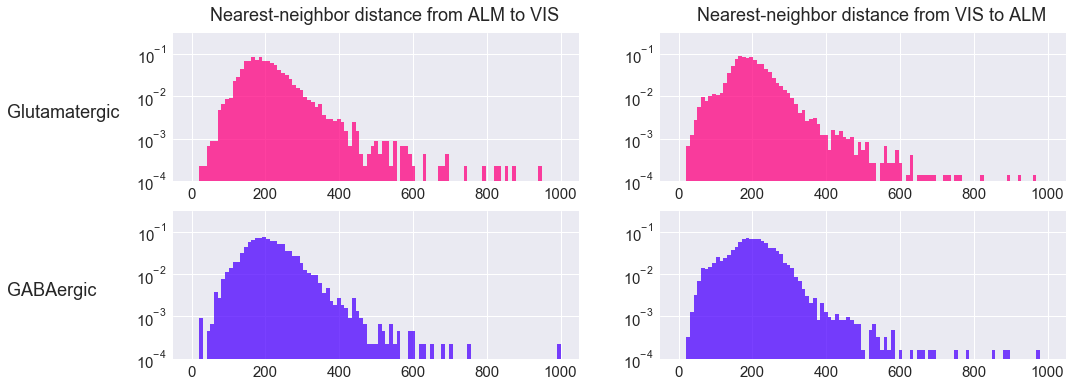

In [11]:
plot_nearest_neighbor_dist()

In [12]:
import pickle

min_dist_dict = {}
min_dist_dict['ALM_ex'] = min_dist_ALM_ex
min_dist_dict['ALM_in'] = min_dist_ALM_in
min_dist_dict['VIS_ex'] = min_dist_VIS_ex
min_dist_dict['VIS_in'] = min_dist_VIS_in

save_path = '/Users/cstoneki/Documents/data/gene_expression/tasic_vis_alm_2018/outputs/'

pickle.dump(min_dist_dict, open(save_path + 'NN_dist_genes_normalized_sd.pickle', 'wb'))


In [13]:
print(np.median(min_dist_ALM_ex))
print(np.median(min_dist_ALM_in))
print(np.median(min_dist_VIS_ex))
print(np.median(min_dist_VIS_in))

192.346238946
203.350304804
191.694929211
200.732383555


In [72]:
#compute euclidean distance from centroid

def euclidean_distance_mat2vec(M, v):
    return np.sqrt(np.sum(np.square(M - np.tile(v[np.newaxis,:], [M.shape[0], 1])), axis=1))

ex_cells = Z[metadata['class']=='Glutamatergic',:]
in_cells = Z[metadata['class']=='GABAergic',:]

ALM_ex_cells = Z[np.logical_and(metadata['brain_region']=='ALM',  metadata['class']=='Glutamatergic'),:]
ALM_in_cells = Z[np.logical_and(metadata['brain_region']=='ALM',  metadata['class']=='GABAergic'),:]
VIS_ex_cells = Z[np.logical_and(metadata['brain_region']=='VISp', metadata['class']=='Glutamatergic'),:]
VIS_in_cells = Z[np.logical_and(metadata['brain_region']=='VISp', metadata['class']=='GABAergic'),:]

ex_centroid = np.mean(ex_cells, axis=0)
in_centroid = np.mean(in_cells, axis=0)

ALM_ex_centroid = np.mean(ALM_ex_cells, axis=0)
ALM_in_centroid = np.mean(ALM_in_cells, axis=0)
VIS_ex_centroid = np.mean(VIS_ex_cells, axis=0)
VIS_in_centroid = np.mean(VIS_in_cells, axis=0)
    

ex_AlM_to_global_diff = euclidean_distance_mat2vec(ALM_ex_cells, ex_centroid)
ex_VIS_to_global_diff = euclidean_distance_mat2vec(VIS_ex_cells, ex_centroid)
ex_AlM_to_ALM_diff = euclidean_distance_mat2vec(ALM_ex_cells, ALM_ex_centroid)
ex_VIS_to_VIS_diff = euclidean_distance_mat2vec(VIS_ex_cells, VIS_ex_centroid)

in_AlM_to_global_diff = euclidean_distance_mat2vec(ALM_in_cells, in_centroid)
in_VIS_to_global_diff = euclidean_distance_mat2vec(VIS_in_cells, in_centroid)
in_AlM_to_ALM_diff = euclidean_distance_mat2vec(ALM_in_cells, ALM_in_centroid)
in_VIS_to_VIS_diff = euclidean_distance_mat2vec(VIS_in_cells, VIS_in_centroid)


In [5]:
def euclidean_distance(v1, v2):
    return np.sqrt(np.dot(v1-v2, v1-v2))

print('Euclidean distance of ALM and VISp centroids for glutamatergic = %.3f'%
      euclidean_distance(ALM_ex_centroid, VIS_ex_centroid))
print('Euclidean distance of ALM and VISp centroids for GABAergic = %.3f'%
      euclidean_distance(ALM_in_centroid, VIS_in_centroid))

Euclidean distance of ALM and VISp centroids for glutamatergic = 11991.902
Euclidean distance of ALM and VISp centroids for GABAergic = 5631.753


In [96]:
def plot_dist_to_centroid():
    import matplotlib.pyplot as plt
    import seaborn

    normalize = False

    plt.rcParams["figure.figsize"] = [16,6]

    seaborn.set(font_scale=1.5)
    text_size = 20
    tick_size = 8


    #print(glut_fraction_new)
    
    #compute histograms
    n_bins = 70
    
    global_max = np.max(np.array([np.max(v) for v in [ex_AlM_to_global_diff, 
                                                      ex_AlM_to_ALM_diff,
                                                      ex_VIS_to_global_diff,
                                                      ex_VIS_to_VIS_diff,
                                                      in_AlM_to_global_diff, 
                                                      in_AlM_to_ALM_diff,
                                                      in_VIS_to_global_diff,
                                                      in_VIS_to_VIS_diff]]))
                                                      
    #global_max = 10**2
    
    h_ex_ALM_global, bin_edges = np.histogram(ex_AlM_to_global_diff[np.logical_not(np.isnan(ex_AlM_to_global_diff))],
                                              bins = np.linspace(0, global_max, n_bins))
    h_ex_ALM_global = h_ex_ALM_global/float(np.sum(h_ex_ALM_global))
    
    h_ex_ALM_ALM, bin_edges = np.histogram(ex_AlM_to_ALM_diff[np.logical_not(np.isnan(ex_AlM_to_ALM_diff))],
                                              bins = np.linspace(0, global_max, n_bins))
    h_ex_ALM_ALM = h_ex_ALM_ALM/float(np.sum(h_ex_ALM_ALM))
    
    h_ex_VIS_global, bin_edges = np.histogram(ex_VIS_to_global_diff[np.logical_not(np.isnan(ex_VIS_to_global_diff))],
                                              bins = np.linspace(0, global_max, n_bins))
    h_ex_VIS_global = h_ex_VIS_global/float(np.sum(h_ex_VIS_global))
    
    h_ex_VIS_VIS, bin_edges = np.histogram(ex_VIS_to_VIS_diff[np.logical_not(np.isnan(ex_VIS_to_VIS_diff))],
                                              bins = np.linspace(0, global_max, n_bins))
    h_ex_VIS_VIS = h_ex_VIS_VIS/float(np.sum(h_ex_VIS_VIS))
    
    h_in_ALM_global, bin_edges = np.histogram(in_AlM_to_global_diff[np.logical_not(np.isnan(in_AlM_to_global_diff))],
                                              bins = np.linspace(0, global_max, n_bins))
    h_in_ALM_global = h_in_ALM_global/float(np.sum(h_in_ALM_global))
    
    h_in_ALM_ALM, bin_edges = np.histogram(in_AlM_to_ALM_diff[np.logical_not(np.isnan(in_AlM_to_ALM_diff))],
                                              bins = np.linspace(0, global_max, n_bins))
    h_in_ALM_ALM = h_in_ALM_ALM/float(np.sum(h_in_ALM_ALM))
    
    h_in_VIS_global, bin_edges = np.histogram(in_VIS_to_global_diff[np.logical_not(np.isnan(in_VIS_to_global_diff))],
                                              bins = np.linspace(0, global_max, n_bins))
    h_in_VIS_global = h_in_VIS_global/float(np.sum(h_in_VIS_global))
    
    h_in_VIS_VIS, bin_edges = np.histogram(in_VIS_to_VIS_diff[np.logical_not(np.isnan(in_VIS_to_VIS_diff))],
                                              bins = np.linspace(0, global_max, n_bins))
    h_in_VIS_VIS = h_in_VIS_VIS/float(np.sum(h_in_VIS_VIS))
        

    bin_width = np.mean(bin_edges[1:] - bin_edges[:-1])
    
    fig, axes = plt.subplots(nrows = 2, ncols = 2)
    
    plt.rcParams["figure.figsize"] = [9,7]
    
    plt.sca(axes[0,0])
    plt.bar(bin_edges[:-1], h_ex_ALM_global, width=bin_width, align='edge', color=[0.5, 0.5, 0.5], alpha=0.75, label='from glut. centroid')
    plt.bar(bin_edges[:-1], h_ex_ALM_ALM, width=bin_width, align='edge', color=[1, 0, 0.5], alpha=0.5, label='from glut. ALM centroid')
    plt.ylim([10**(-4), 10**(-0.5)])
    axes[0,0].set_yscale('log')
    plt.text(0.5*10**2,0.6,'ALM')
    plt.text(-0.8*10**3,10**(-2.5), 'Glutamatergic') 
    axes[0,0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    plt.xticks([0, 0.5*10**3, 10**3, 1.5*10**3])
    plt.legend()
    
    plt.sca(axes[0,1])
    plt.bar(bin_edges[:-1], h_ex_VIS_global, width=bin_width, align='edge', color=[0.5, 0.5, 0.5], alpha=0.75, label='from glut. centroid')
    plt.bar(bin_edges[:-1], h_ex_VIS_VIS, width=bin_width, align='edge', color=[1, 0, 0.5], alpha=0.5, label='from glut. VIS centroid')
    plt.ylim([10**(-4), 10**(-0.5)])
    axes[0,1].set_yscale('log')
    #plt.xticks([0, 1], ['ALM', 'VISp'])
    plt.text(0.5*10**2,0.6,'VIS')
    axes[0,1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    plt.xticks([0, 0.5*10**3, 10**3, 1.5*10**3])
    plt.legend()
    
    plt.sca(axes[1,0])
    plt.bar(bin_edges[:-1], h_in_ALM_global, width=bin_width, align='edge', color=[0.5, 0.5, 0.5], alpha=0.75, label='from GABA centroid')
    plt.bar(bin_edges[:-1], h_in_ALM_ALM, width=bin_width, align='edge', color=[0.3, 0, 1], alpha=0.5, label='from GABA ALM centroid')
    plt.ylim([10**(-4), 10**(-0.5)])
    axes[1,0].set_yscale('log')
    #plt.xticks([0, 1], ['ALM', 'VISp'])
    plt.text(-0.8*10**3,10**(-2.5), 'GABAergic') 
    axes[1,0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    plt.xticks([0, 0.5*10**3, 10**3, 1.5*10**3])
    plt.legend()
    
    plt.sca(axes[1,1])
    plt.bar(bin_edges[:-1], h_in_VIS_global, width=bin_width, align='edge', color=[0.5, 0.5, 0.5], alpha=0.75, label='from GABA centroid')
    plt.bar(bin_edges[:-1], h_in_VIS_VIS, width=bin_width, align='edge', color=[0.3, 0, 1], alpha=0.5, label='from GABA VIS centroid')
    plt.ylim([10**(-4), 10**(-0.5)])
    axes[1,1].set_yscale('log')
    axes[1,1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    plt.xticks([0, 0.5*10**3, 10**3, 1.5*10**3])
    plt.legend()

    plt.subplots_adjust(hspace=0.3)
        
    
    plt.show()

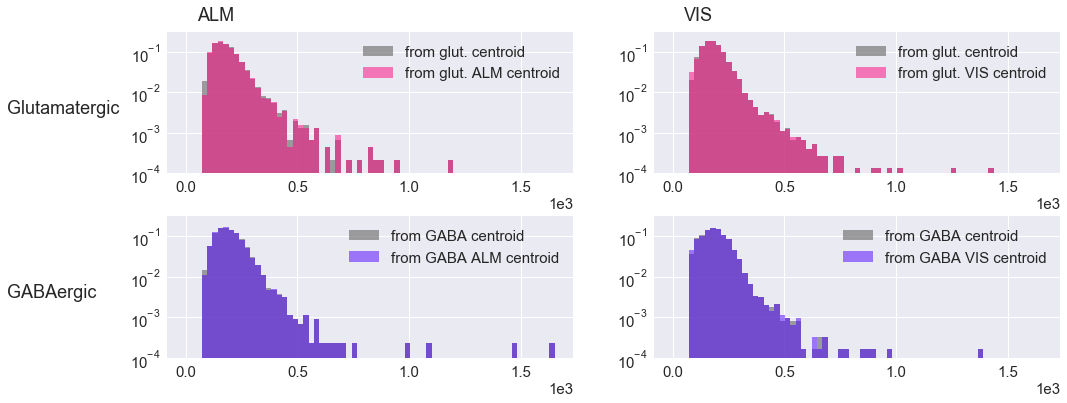

In [97]:
plot_dist_to_centroid()

In [ ]:
#classifier analysis


In [25]:
import lightgbm as lgbm
import time

In [16]:
from sklearn.model_selection import KFold

default_params = {
    'verbosity' : -1,
    'objective' :'binary',
    'learning_rate' : 0.02,
    'num_leaves' : 40, #could increase this, increases time negligibly but does not increase performance
    'min_data_in_leaf' : 20, #20 = the default value, might want to lower it, but that hasn't made difference so far
    'max_depth' : -1, # -1 -> no depth limit - default
    'feature_fraction': 1, #in tests, reducing this made it slower and hurt performance. Not a win.
    'bagging_fraction': 0.5, #values between 0.5-0.8 seem to work well
    'bagging_freq':1,
    'boosting_type' : 'gbdt',
    'metric': 'binary_logloss'
}

#train a lightgbm classifier
#estimate error using k-fold crossvalidation
#we don't actually have a test set in this context 
#(cluster identities are known for all cells)
def kfold_lightgbm(df, num_folds, classes, params=default_params):

    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    
    df_sub = df[np.logical_or(df['class_label']==classes[0],df['class_label']==classes[1])]
    df_sub['class_label'] = df_sub['class_label']==classes[1]
    feats = [f for f in df_sub.columns if f not in ['class_label', 'index']]
    
    out_of_fold_pred = np.zeros(len(df_sub))
    
    
    for n_fold, (train_set, test_set) in enumerate(folds.split(df_sub[feats], df_sub['class_label'])):
        
        train_x, train_y = df_sub[feats].iloc[train_set].values, df_sub['class_label'].iloc[train_set].values
        valid_x, valid_y = df_sub[feats].iloc[test_set].values, df_sub['class_label'].iloc[test_set].values
        
        d_train = lgbm.Dataset(train_x, train_y)
        d_valid = lgbm.Dataset(valid_x, valid_y)
    
        # training with early stop
        gbm = lgbm.train(params, d_train, 5000, valid_sets=[d_valid], verbose_eval=False, early_stopping_rounds=100)
        
        out_of_fold_pred[test_set] = gbm.predict(valid_x, num_iteration=gbm.best_iteration)
        
    out_of_fold_pred = np.floor(out_of_fold_pred + 0.5)
    #force prediction to be 0 or 1
        
    accuracy = np.mean(out_of_fold_pred==df_sub['class_label'])
    
    if(accuracy < 0.5): accuracy = 1 - accuracy
    
    
    return accuracy

In [23]:
X_reduced_ex = X_reduced[metadata['class']=='Glutamatergic',:]
X_reduced_in = X_reduced[metadata['class']=='GABAergic',:]
labels_ex = metadata['brain_region'][metadata['class']=='Glutamatergic']
labels_in = metadata['brain_region'][metadata['class']=='GABAergic']

In [26]:

#run the classifier on excitatory
df_classifier_ex = pd.DataFrame(X_reduced_ex)
df_classifier_ex['class_label'] = labels_ex.values
t0 = time.time()
accuracy_ex = kfold_lightgbm(df_classifier_ex, 10, ["ALM", "VISp"])
t_elapsed = time.time() - t0
print('Ran classifier analysis in %f minutes'%(t_elapsed/60.0))
print(accuracy_ex)

Ran classifier analysis in 22.337781 minutes
0.993784124318


In [27]:

#run the classifier on excitatory
df_classifier_in = pd.DataFrame(X_reduced_in)
df_classifier_in['class_label'] = labels_in.values
t0 = time.time()
accuracy_in = kfold_lightgbm(df_classifier_in, 10, ["ALM", "VISp"])
t_elapsed = time.time() - t0
print('Ran classifier analysis in %f minutes'%(t_elapsed/60.0))
print(accuracy_in)

Ran classifier analysis in 31.020520 minutes
0.897569774065


In [53]:
from sklearn.cluster import AgglomerativeClustering
#agg = AgglomerativeClustering(n_clusters=100, affinity='precomputed', memory=None, connectivity=None, compute_full_tree='auto', linkage='complete')
#agg = agg.fit(C_reduced)

agg = AgglomerativeClustering(n_clusters=120, affinity='euclidean', memory=None, connectivity=None, compute_full_tree='auto', linkage='ward')
agg = agg.fit(X_reduced_filtered)
clustering = agg.labels_


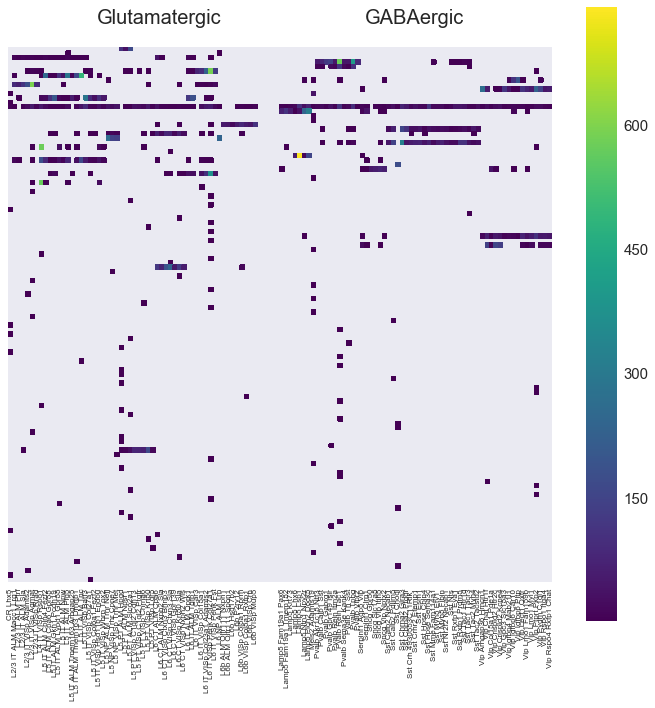

In [54]:
plot_breakdown_matrix(clustering, (10,10))

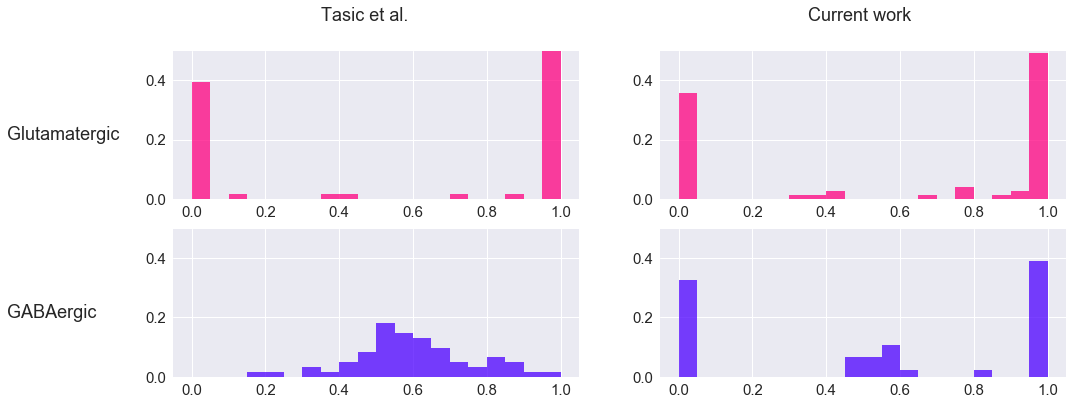

In [55]:
plot_area_specificity(clustering)

### ii. Plot area specificity of each cluster

Here I generate a plot which shows the area specificity of each cluster, with an axis where 0 = totally ALM-specific and 1 = totally VISp - specific. Only for neurons (glutamatergic and GABAergic).

In [165]:
x_to_plot = []
y_to_plot = []
text_to_plot = []
color_to_plot = []

unique_clusters_ex = list(set(full_data_ex['cluster'].values))

y0 = 0
y = 0
dy = 1

for c in unique_clusters_ex:
    cluster_size_total = float(np.sum(full_data_ex['cluster']==c))
    cluster_size_vis   = float(np.sum(np.logical_and(full_data_ex['cluster']==c, full_data_ex['brain_region']=='VISp')))
    vis_spec = cluster_size_vis/cluster_size_total
    x_to_plot.append(vis_spec)
    y_to_plot.append(y)
    y = y + dy
    color_to_plot.append([1, 0.2, 0])
    text_to_plot.append(c)
    
unique_clusters_in = list(set(full_data_in['cluster'].values))

y = y + 10
    
for c in unique_clusters_in:
    cluster_size_total = float(np.sum(full_data_in['cluster']==c))
    cluster_size_vis   = float(np.sum(np.logical_and(full_data_in['cluster']==c, full_data_in['brain_region']=='VISp')))
    vis_spec = cluster_size_vis/cluster_size_total
    x_to_plot.append(vis_spec)
    y_to_plot.append(y)
    y = y + dy
    color_to_plot.append([0, 0.4, 1])
    text_to_plot.append(c)

    

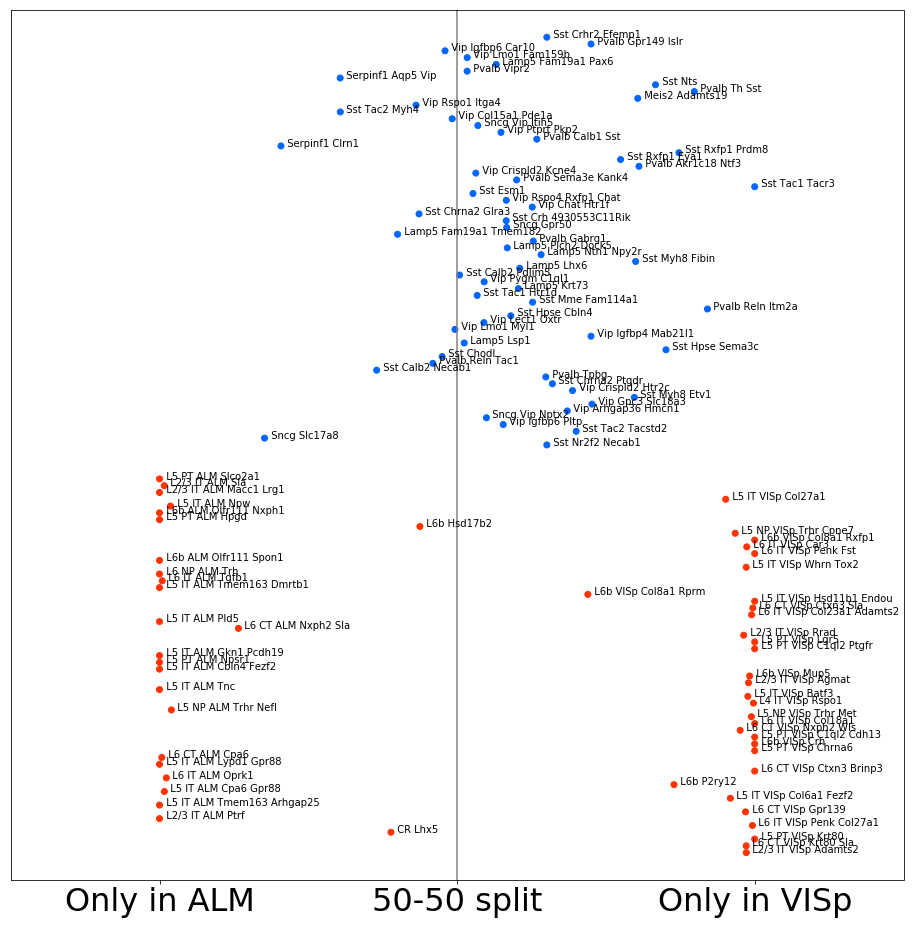

In [179]:
plt.rcParams["figure.figsize"] = [16,16]

fig, ax = plt.subplots()
ax.scatter(x_to_plot, y_to_plot, c=color_to_plot)

for i, txt in enumerate(text_to_plot):
    ax.annotate('  '+txt, (x_to_plot[i], y_to_plot[i]))
    
plt.plot([0.5, 0.5], [-2, 1000], c=[0.5, 0.5, 0.5])
    
ax.get_yaxis().set_visible(False)
plt.xticks([0, 0.5, 1], ['Only in ALM', '50-50 split', 'Only in VISp'], fontsize=32)

plt.xlim([-0.25, 1.25])
plt.ylim([-2, np.max(np.array(y_to_plot) + 2)])
    
plt.show()

### iii. Plot all points/clusters embedded in 2D space

In [ ]:
full_data = pd.concat([full_data_ex, full_data_in], axis=0)

### 1. Analyzing similarities in excitatory clusters between VISp and ALM

Here I use the correlation between cluster centroids to determine how similar the clusters from VISp are to the clusters from ALM. In particular, I find the assignment of ALM clusters to VISp clusters that maximizes the sum of correlations of the cluster centroids. I use this assignment to run supervised MetaNeighbor - i.e. I assume that the clusters from VISp and ALM that are assigned to each other are instances of the same cluster, and treat the ALM and VISp data as if they came from different experiments, then ask how well the cluster properties are preserved between these two pseudo-experiments.

In [25]:
area_specificity_cutoff = 0.95
#this is the minimum specificity that a given cluster must have for vis or alm
#to be considered as belonging exclusively to vis or alm

In [26]:
unique_clusters = list(set(full_data_ex['cluster'].values))
unique_clusters_vis = []
unique_clusters_alm = []
unique_clusters_both = []
for c in unique_clusters:
    cluster_size_total = float(np.sum(full_data_ex['cluster']==c))
    cluster_size_vis   = float(np.sum(np.logical_and(full_data_ex['cluster']==c, full_data_ex['brain_region']=='VISp')))
    vis_spec = cluster_size_vis/cluster_size_total
    if(vis_spec >= area_specificity_cutoff):
        unique_clusters_vis.append(c)
    elif(vis_spec <= 1 - area_specificity_cutoff):
        unique_clusters_alm.append(c)
    else:
        unique_clusters_both.append(c)

In [27]:
print('Using area specificity cutoff = %.2f\n'%area_specificity_cutoff)
print('(This is the minimum fraction of cluster members that must be from one area, for the cluster to be considered as unique to that area)\n')
print('%d clusters are unique to VISp - these are:\n'%len(unique_clusters_vis))
print(unique_clusters_vis)
print('\n%d clusters are unique to ALM - these are:\n'%len(unique_clusters_alm))
print(unique_clusters_alm)
print('\n%d clusters are found in both areas - these are:\n'%len(unique_clusters_both))
print(unique_clusters_both)

Using area specificity cutoff = 0.95

(This is the minimum fraction of cluster members that must be from one area, for the cluster to be considered as unique to that area)

29 clusters are unique to VISp - these are:

['L2/3 IT VISp Adamts2', 'L6 CT VISp Krt80 Sla', 'L5 PT VISp Krt80', 'L6 IT VISp Penk Col27a1', 'L6 CT VISp Gpr139', 'L5 IT VISp Col6a1 Fezf2', 'L6 CT VISp Ctxn3 Brinp3', 'L5 PT VISp Chrna6', 'L6b VISp Crh', 'L5 PT VISp C1ql2 Cdh13', 'L6 CT VISp Nxph2 Wls', 'L6 IT VISp Col18a1', 'L5 NP VISp Trhr Met', 'L4 IT VISp Rspo1', 'L5 IT VISp Batf3', 'L2/3 IT VISp Agmat', 'L6b VISp Mup5', 'L5 PT VISp C1ql2 Ptgfr', 'L5 PT VISp Lgr5', 'L2/3 IT VISp Rrad', 'L6 IT VISp Col23a1 Adamts2', 'L6 CT VISp Ctxn3 Sla', 'L5 IT VISp Hsd11b1 Endou', 'L5 IT VISp Whrn Tox2', 'L6 IT VISp Penk Fst', 'L6 IT VISp Car3', 'L6b VISp Col8a1 Rxfp1', 'L5 NP VISp Trhr Cpne7', 'L5 IT VISp Col27a1']

22 clusters are unique to ALM - these are:

['L2/3 IT ALM Ptrf', 'L5 IT ALM Tmem163 Arhgap25', 'L5 IT ALM Cpa6 Gp

In [28]:
#find centroids of clusters
#we only use cells from the given area to compute the centroid!

is_gene_column = np.array([isinstance(col, int) for col in full_data_ex.columns])
#X_vis = vis_data.values[:,is_gene_column]
#make sure that all values are numeric by casting to float:
#X_vis = X_vis.astype(float)
centroids_vis = np.zeros([len(unique_clusters_vis), np.sum(is_gene_column)])
centroids_alm = np.zeros([len(unique_clusters_alm), np.sum(is_gene_column)])

for n,c in enumerate(unique_clusters_vis):
    X = full_data_ex.loc[np.logical_and(full_data_ex['cluster']==c, full_data_ex['brain_region']=='VISp')].values[:, is_gene_column].astype(float)
    centroids_vis[n,:] = np.mean(X, axis=0)
for n,c in enumerate(unique_clusters_alm):
    X = full_data_ex.loc[np.logical_and(full_data_ex['cluster']==c, full_data_ex['brain_region']=='ALM')].values[:, is_gene_column].astype(float)
    centroids_alm[n,:] = np.mean(X, axis=0)

In [29]:
def compute_correlation_matrix(X1, X2):

    X1 = X1 - np.tile(np.mean(X1, axis=1)[:, np.newaxis], (1, X1.shape[1]))
    X1 = X1/np.tile(np.std(X1, axis=1)[:, np.newaxis], (1, X1.shape[1]))
    X2 = X2 - np.tile(np.mean(X2, axis=1)[:, np.newaxis], (1, X2.shape[1]))
    X2 = X2/np.tile(np.std(X2, axis=1)[:, np.newaxis], (1, X2.shape[1]))
    
    return np.matmul(X1, np.transpose(X2))/X1.shape[1]

In [30]:
from munkres import Munkres

def order_similarity_matrix(A):
    m = Munkres()
    cost_matrix = 1 - A
    indices = m.compute(cost_matrix.tolist()) #need to convert to list for munkres, otherwise it fails
    B = np.zeros(A.shape)
    row_indices = np.zeros(A.shape[0]).astype(int)
    for i in range(len(indices)):
        B[indices[i][1],:] = A[indices[i][0],:]
        row_indices[indices[i][1]] = indices[i][0]
    return [B, row_indices]

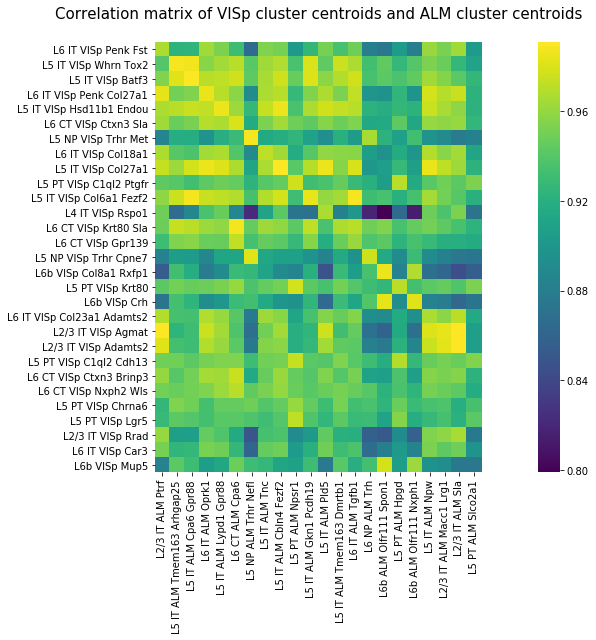

In [31]:
corr_mat = compute_correlation_matrix(centroids_vis, centroids_alm)
#add dummy columns to corr_mat
corr_mat_extended = np.concatenate([corr_mat, np.min(corr_mat)*np.ones([corr_mat.shape[0], corr_mat.shape[0] - corr_mat.shape[1]])], axis=1)
[corr_ordered, row_indices] = order_similarity_matrix(corr_mat_extended)
#row_indices gives permutation applied to rows

#plot corr_mat without dummy columns
#(these are still all at the end, because we only permuted the rows)
corr_ordered_to_plot = corr_ordered[:,0:corr_mat.shape[1]]

                                                                  
plt.rcParams["figure.figsize"] = [16,9]
ax = plt.gca()
im = seaborn.heatmap(corr_ordered_to_plot, yticklabels = [unique_clusters_vis[r] for r in row_indices], xticklabels=unique_clusters_alm , cmap = plt.get_cmap('viridis'), square = True)

#plt.xticks(np.arange(0.5,corr_ordered.shape[0], 1), np.arange(1, corr_ordered.shape[0] + 1, 1))
#plt.yticks(np.arange(0.5,corr_ordered.shape[0], 1), row_indices)


ax.set_title("Correlation matrix of VISp cluster centroids and ALM cluster centroids\n", fontsize = 15)
plt.tight_layout()
plt.show()

In [103]:
permute_vis = False
supervised  = False
#note that if supervised = False (i.e. unsupervised metaneighbor),
#then permute_vis is irrelevant

In [102]:


if(permute_vis):
    row_indices_to_use = row_indices[0:corr_mat.shape[1]]
    vis_clusters_to_use = [unique_clusters_vis[r] for r in np.random.permutation(row_indices_to_use)][0:corr_mat.shape[1]]
else:
    vis_clusters_to_use = [unique_clusters_vis[r] for r in row_indices][0:corr_mat.shape[1]]
alm_clusters_to_use = unique_clusters_alm

data_to_use = full_data_ex.loc[[c in vis_clusters_to_use or c in alm_clusters_to_use for c in full_data_ex['cluster']]]



In [95]:
data_to_use.shape

(10833, 45817)

In [34]:
# #reduce size of gene expression matrix if needed
#import sklearn.decomposition
#from sklearn.decomposition import PCA
#pca = sklearn.decomposition.PCA(n_components=4000)
#gene_expression_reduced = pca.fit_transform(data_to_use.values[:, is_gene_column])

In [96]:
vis_gene_names = pd.read_csv(main_folder + '/' + vis_subfolder + '/' + vis_gene_names_file)
alm_gene_names = pd.read_csv(main_folder + '/' + alm_subfolder + '/' + alm_gene_names_file)

In [97]:
vis_gene_names.columns

Index([u'gene_symbol', u'gene_id', u'chromosome', u'gene_entrez_id',
       u'gene_name'],
      dtype='object')

In [104]:
#convert to .csv for analysis with supervised or unsupervised metaneighbor in R

MN_gene_expression = pd.DataFrame(data=np.transpose(data_to_use.values[:, is_gene_column]), index = vis_gene_names['gene_symbol'])
#gene expression matrix for metaneighbor
#needs to be gene-by-sample



MN_cell_type = np.array(data_to_use['cluster'].values)

if(supervised):
    #replace all ALM cell type names with corresponding VISp cell type names
    for n, alm_type in enumerate(alm_clusters_to_use):
        MN_cell_type[np.where(MN_cell_type==alm_type)[0]] = vis_clusters_to_use[n]

MN_sample_ID = data_to_use.index

#act as if different brain regions come from different studies
MN_study_ID = data_to_use['brain_region']

unique_cell_types = list(set(MN_cell_type))

MN_cell_labels = np.zeros([MN_gene_expression.shape[1], len(unique_cell_types)])

for n, t in enumerate(unique_cell_types):
    MN_cell_labels[:,n] = MN_cell_type==t

                           





In [105]:
output_folder = '/Users/cstoneki/Documents/data/gene_expression/MN_04_unsupervised/'
pd.DataFrame(data=MN_gene_expression).to_csv(output_folder+'MN_gene_expression.csv')

In [106]:
pd.DataFrame(data=MN_cell_type).to_csv(output_folder+'MN_cell_type.csv')
pd.DataFrame(data=MN_sample_ID).to_csv(output_folder+'MN_sample_ID.csv')
pd.DataFrame(data=MN_study_ID).to_csv(output_folder+'MN_study_ID.csv')
pd.DataFrame(data=MN_cell_labels).to_csv(output_folder+'MN_cell_labels.csv')

### 2. How well can we discriminate VIS from ALM?

Here, I train a classifier (lightgbm) to attempt to discriminate VIS from ALM, based on gene expression data.

First discrimination analysis: how well can we discriminate VIS from ALM in inhibitory neuron types that are found in both areas?

In [38]:
import lightgbm as lgbm

In [39]:
from sklearn.model_selection import KFold

default_params = {
    'verbosity' : -1,
    'objective' :'binary',
    'learning_rate' : 0.02,
    'num_leaves' : 40, #could increase this, increases time negligibly but does not increase performance
    'min_data_in_leaf' : 20, #20 = the default value, might want to lower it, but that hasn't made difference so far
    'max_depth' : -1, # -1 -> no depth limit - default
    'feature_fraction': 1, #in tests, reducing this made it slower and hurt performance. Not a win.
    'bagging_fraction': 0.5, #values between 0.5-0.8 seem to work well
    'bagging_freq':1,
    'boosting_type' : 'gbdt',
    'metric': 'binary_logloss'
}

#train a lightgbm classifier
#estimate error using k-fold crossvalidation
#we don't actually have a test set in this context 
#(cluster identities are known for all cells)
def kfold_lightgbm(df, num_folds, classes, params=default_params):

    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    
    df_sub = df[np.logical_or(df['class_label']==classes[0],df['class_label']==classes[1])]
    df_sub['class_label'] = df_sub['class_label']==classes[1]
    feats = [f for f in df_sub.columns if f not in ['class_label', 'index']]
    
    out_of_fold_pred = np.zeros(len(df_sub))
    
    
    for n_fold, (train_set, test_set) in enumerate(folds.split(df_sub[feats], df_sub['class_label'])):
        
        train_x, train_y = df_sub[feats].iloc[train_set].values, df_sub['class_label'].iloc[train_set].values
        valid_x, valid_y = df_sub[feats].iloc[test_set].values, df_sub['class_label'].iloc[test_set].values
        
        d_train = lgbm.Dataset(train_x, train_y)
        d_valid = lgbm.Dataset(valid_x, valid_y)
    
        # training with early stop
        gbm = lgbm.train(params, d_train, 5000, valid_sets=[d_valid], verbose_eval=False, early_stopping_rounds=100)
        
        out_of_fold_pred[test_set] = gbm.predict(valid_x, num_iteration=gbm.best_iteration)
        
    out_of_fold_pred = np.floor(out_of_fold_pred + 0.5)
    #force prediction to be 0 or 1
        
    accuracy = np.mean(out_of_fold_pred==df_sub['class_label'])
    
    if(accuracy < 0.5): accuracy = 1 - accuracy
    
    
    return accuracy

In [40]:
#only take subtypes that are present in both brain areas to a certain degree
area_representation_cutoff = 0.33
#subtype must have at least this fraction present in each area


In [44]:
unique_clusters = list(set(full_data_in['cluster'].values))
shared_clusters =  []
nonshared_clusters = []
shared_minority_fraction = []
nonshared_minority_fraction = []
for c in unique_clusters:
    cluster_size_total = float(np.sum(full_data_in['cluster']==c))
    cluster_size_vis   = float(np.sum(np.logical_and(full_data_in['cluster']==c, full_data_in['brain_region']=='VISp')))
    minority_fraction = min(cluster_size_vis/cluster_size_total, 1 - cluster_size_vis/cluster_size_total)
    if(minority_fraction >= area_representation_cutoff):
        shared_clusters.append(c)
        shared_minority_fraction.append(minority_fraction)
    else:
        nonshared_clusters.append(c)
        nonshared_minority_fraction.append(minority_fraction)

In [46]:
print('Using area representation cutoff = %.2f\n'%area_representation_cutoff)
print('\n(This is the minimum fraction of cluster members that must be present in the less favored area, for the cluster to be considered shared)\n')
print('\n%d clusters are considered shared - these are:\n'%len(shared_clusters))
print(shared_clusters)
#print('\nThese have minority fractions (fraction of cluster members present in the less favored area) of:')
#print(shared_minority_fraction)
print('\n%d clusters are considered not shared - these are:\n'%len(nonshared_clusters))
print(nonshared_clusters)
#print('\nThese have minority fractions (fraction of cluster members present in the less favored area) of:')
#print(nonshared_minority_fraction)

Using area representation cutoff = 0.33


(This is the minimum fraction of cluster members that must be present in the less favored area, for the cluster to be considered shared)


40 clusters are considered shared - these are:

['Sst Nr2f2 Necab1', 'Vip Igfbp6 Pltp', 'Sncg Vip Nptx2', 'Sst Chrna2 Ptgdr', 'Pvalb Tpbg', 'Sst Calb2 Necab1', 'Pvalb Reln Tac1', 'Sst Chodl', 'Lamp5 Lsp1', 'Vip Lmo1 Myl1', 'Vip Lect1 Oxtr', 'Sst Hpse Cbln4', 'Sst Mme Fam114a1', 'Sst Tac1 Htr1d', 'Lamp5 Krt73', 'Vip Pygm C1ql1', 'Sst Calb2 Pdlim5', 'Lamp5 Lhx6', 'Lamp5 Ntn1 Npy2r', 'Lamp5 Plch2 Dock5', 'Pvalb Gabrg1', 'Lamp5 Fam19a1 Tmem182', 'Sncg Gpr50', 'Sst Crh 4930553C11Rik ', 'Sst Chrna2 Glra3', 'Vip Chat Htr1f', 'Vip Rspo4 Rxfp1 Chat', 'Sst Esm1', 'Pvalb Sema3e Kank4', 'Vip Crispld2 Kcne4', 'Pvalb Calb1 Sst', 'Vip Ptprt Pkp2', 'Sncg Vip Itih5', 'Vip Col15a1 Pde1a', 'Vip Rspo1 Itga4', 'Pvalb Vipr2', 'Lamp5 Fam19a1 Pax6', 'Vip Lmo1 Fam159b', 'Vip Igfbp6 Car10', 'Sst Crhr2 Efemp1']

21 clusters are consid

In [53]:
shared_cell_indices = []

for sc in shared_clusters:
    shared_cell_indices = shared_cell_indices + list(np.where(full_data_in['cluster']==sc)[0])





In [55]:
full_data_in_shared = full_data_in.iloc[shared_cell_indices]
#create dataframe for classifier
class_label = pd.Series(data = full_data_in_shared['brain_region'] , index = full_data_in_shared.index)

In [56]:
import sklearn.decomposition


#reduce dimensionality
#to run metaneighbor, need to reduce size of gene expression matrix
pca = sklearn.decomposition.PCA(n_components=4000)
data_for_classifier_reduced = pca.fit_transform(full_data_in_shared.loc[:,is_gene_column].values)


In [63]:
df_classifier = pd.DataFrame(data_for_classifier_reduced)
df_classifier['class_label'] = class_label.values

In [65]:
#run the classifier
t0 = time.time()
accuracy = kfold_lightgbm(df_classifier, 10, ["ALM", "VISp"])
t_elapsed = time.time() - t0
print('Ran classifier analysis in %f minutes'%(t_elapsed/60.0))
print(accuracy)

Ran classifier analysis in 147.779196 minutes
0.893107617896


So if we train a classifier on the gene expression profiles of inhibitory neuron types that are found in both VISp and ALM, then it does a decent job of predicting the area from the gene expression.
We can't interpret this value at a precise quantitative level  because it depends a lot on the classifier (e.g. if I tried to optimize it further, I would probably be able to increase the value).

As a control/point of comparison, I want to determine how well we can classify area if we do not directly use the gene expression, but we do use the subtype (cluster) identity, and we know the base rate of occurrence of each subtype in each area.

In [66]:
n_total = 0
n_correct = 0
for c in shared_clusters:
    cluster_size_total = float(np.sum(full_data_in['cluster']==c))
    cluster_size_vis   = float(np.sum(np.logical_and(full_data_in['cluster']==c, full_data_in['brain_region']=='VISp')))
    majority_fraction = max(cluster_size_vis/cluster_size_total, 1 - cluster_size_vis/cluster_size_total)
    n_correct = n_correct + cluster_size_total*majority_fraction
    n_total = n_total + cluster_size_total

print('For classification using only knowledge of the relative frequency of each area for each subtype:')
print('\naccuracy = %f'%accuracy)

For classification using only knowledge of the relative frequency of each area for each subtype:

accuracy = 0.893108


So actually, it turns out that the classifier might only predict something that more-or-less corresponds to cluster identity, and then predict area on the basis of this.

Now I want to use only interneurons that are quite equitably shared between areas, i.e. fraction of each area is close to 50%. 

### 3. Differences between areas

In this section, I analyze the differences in gene expression profile between areas. To do so, I take excitatory and inhibitory neuron types which are present in both areas. In the case of inhibitory neurons, many types are represented in both areas. In the case of excitatory neurons, I take pairs of clusters which seem to belong to a single type, as suggested by the previous MetaNeighbor analysis.

In [89]:
#selecting inhibitory neuron subtypes
#only take subtypes that are present in both brain areas to a certain degree
area_representation_cutoff = 0.33
#subtype must have at least this fraction present in each area


In [90]:
unique_clusters_in = list(set(full_data_in['cluster'].values))
shared_clusters_in =  []
nonshared_clusters_in = []
shared_minority_fraction_in = []
nonshared_minority_fraction_in = []
for c in unique_clusters_in:
    cluster_size_total = float(np.sum(full_data_in['cluster']==c))
    cluster_size_vis   = float(np.sum(np.logical_and(full_data_in['cluster']==c, full_data_in['brain_region']=='VISp')))
    minority_fraction = min(cluster_size_vis/cluster_size_total, 1 - cluster_size_vis/cluster_size_total)
    if(minority_fraction >= area_representation_cutoff):
        shared_clusters_in.append(c)
        shared_minority_fraction_in.append(minority_fraction)
    else:
        nonshared_clusters_in.append(c)
        nonshared_minority_fraction_in.append(minority_fraction)

In [91]:
print('Choosing inhibitory neuron clusters\n')
print('Using area representation cutoff = %.2f\n'%area_representation_cutoff)
print('\n(This is the minimum fraction of cluster members that must be present in the less favored area, for the cluster to be considered shared)\n')
print('\n%d clusters are considered shared - these are:\n'%len(shared_clusters_in))
print(shared_clusters_in)
#print('\nThese have minority fractions (fraction of cluster members present in the less favored area) of:')
#print(shared_minority_fraction)
print('\n%d clusters are considered not shared - these are:\n'%len(nonshared_clusters_in))
print(nonshared_clusters_in)
#print('\nThese have minority fractions (fraction of cluster members present in the less favored area) of:')
#print(nonshared_minority_fraction)

Choosing inhibitory neuron clusters

Using area representation cutoff = 0.33


(This is the minimum fraction of cluster members that must be present in the less favored area, for the cluster to be considered shared)


40 clusters are considered shared - these are:

['Sst Nr2f2 Necab1', 'Vip Igfbp6 Pltp', 'Sncg Vip Nptx2', 'Sst Chrna2 Ptgdr', 'Pvalb Tpbg', 'Sst Calb2 Necab1', 'Pvalb Reln Tac1', 'Sst Chodl', 'Lamp5 Lsp1', 'Vip Lmo1 Myl1', 'Vip Lect1 Oxtr', 'Sst Hpse Cbln4', 'Sst Mme Fam114a1', 'Sst Tac1 Htr1d', 'Lamp5 Krt73', 'Vip Pygm C1ql1', 'Sst Calb2 Pdlim5', 'Lamp5 Lhx6', 'Lamp5 Ntn1 Npy2r', 'Lamp5 Plch2 Dock5', 'Pvalb Gabrg1', 'Lamp5 Fam19a1 Tmem182', 'Sncg Gpr50', 'Sst Crh 4930553C11Rik ', 'Sst Chrna2 Glra3', 'Vip Chat Htr1f', 'Vip Rspo4 Rxfp1 Chat', 'Sst Esm1', 'Pvalb Sema3e Kank4', 'Vip Crispld2 Kcne4', 'Pvalb Calb1 Sst', 'Vip Ptprt Pkp2', 'Sncg Vip Itih5', 'Vip Col15a1 Pde1a', 'Vip Rspo1 Itga4', 'Pvalb Vipr2', 'Lamp5 Fam19a1 Pax6', 'Vip Lmo1 Fam159b', 'Vip Igfbp6 Car10', 'Sst C

In [36]:
unique_clusters_ex = list(set(full_data_ex['cluster'].values))
shared_clusters_ex =  []
nonshared_clusters_ex = []
shared_minority_fraction_ex = []
nonshared_minority_fraction_ex = []
for c in unique_clusters_ex:
    cluster_size_total = float(np.sum(full_data_ex['cluster']==c))
    cluster_size_vis   = float(np.sum(np.logical_and(full_data_ex['cluster']==c, full_data_ex['brain_region']=='VISp')))
    minority_fraction = min(cluster_size_vis/cluster_size_total, 1 - cluster_size_vis/cluster_size_total)
    if(minority_fraction >= area_representation_cutoff):
        shared_clusters_ex.append(c)
        shared_minority_fraction_ex.append(minority_fraction)
    else:
        nonshared_clusters_ex.append(c)
        nonshared_minority_fraction_ex.append(minority_fraction)

In [37]:
print('Choosing excitatory neuron clusters\n')
print('Using area representation cutoff = %.2f\n'%area_representation_cutoff)
print('\n(This is the minimum fraction of cluster members that must be present in the less favored area, for the cluster to be considered shared)\n')
print('\n%d clusters are considered shared - these are:\n'%len(shared_clusters_ex))
print(shared_clusters_ex)
#print('\nThese have minority fractions (fraction of cluster members present in the less favored area) of:')
#print(shared_minority_fraction)
print('\n%d clusters are considered not shared - these are:\n'%len(nonshared_clusters_ex))
print(nonshared_clusters_ex)
#print('\nThese have minority fractions (fraction of cluster members present in the less favored area) of:')
#print(nonshared_minority_fraction)

Choosing excitatory neuron clusters

Using area representation cutoff = 0.33


(This is the minimum fraction of cluster members that must be present in the less favored area, for the cluster to be considered shared)


2 clusters are considered shared - these are:

['CR Lhx5', 'L6b Hsd17b2']

54 clusters are considered not shared - these are:

['L2/3 IT VISp Adamts2', 'L6 CT VISp Krt80 Sla', 'L5 PT VISp Krt80', 'L6 IT VISp Penk Col27a1', 'L2/3 IT ALM Ptrf', 'L6 CT VISp Gpr139', 'L5 IT ALM Tmem163 Arhgap25', 'L5 IT VISp Col6a1 Fezf2', 'L5 IT ALM Cpa6 Gpr88', 'L6b P2ry12', 'L6 IT ALM Oprk1', 'L6 CT VISp Ctxn3 Brinp3', 'L5 IT ALM Lypd1 Gpr88', 'L6 CT ALM Cpa6', 'L5 PT VISp Chrna6', 'L6b VISp Crh', 'L5 PT VISp C1ql2 Cdh13', 'L6 CT VISp Nxph2 Wls', 'L6 IT VISp Col18a1', 'L5 NP VISp Trhr Met', 'L5 NP ALM Trhr Nefl', 'L4 IT VISp Rspo1', 'L5 IT VISp Batf3', 'L5 IT ALM Tnc', 'L2/3 IT VISp Agmat', 'L6b VISp Mup5', 'L5 IT ALM Cbln4 Fezf2', 'L5 PT ALM Npsr1', 'L5 IT ALM Gkn1 Pcdh19', 'L5 PT VISp C1

So 40 out of 61 inhibitory clusters are reasonably well split between areas, but only 2/56 excitatory clusters are. So we add the pairs of excitatory clusters identified by MetaNeighbor. These are the reciprocal top hits from running unsupervised MetaNeighbor.

In [38]:
ex_pairs = pd.DataFrame(columns=['ALM', 'VISp'])
ex_pairs.loc[0] = ['L6b ALM Olfr111 Spon1', 'L6b VISp Col8a1 Rxfp1']
ex_pairs.loc[1] = ['L6b ALM Olfr111 Nxph1', 'L6b VISp Crh']
ex_pairs.loc[2] = ['L5 NP ALM Trhr Nefl', 'L5 NP VISp Trhr Met']
ex_pairs.loc[3] = ['L5 PT ALM Hpgd', 'L5 PT VISp C1ql2 Ptgfr']
ex_pairs.loc[4] = ['L2/3 IT ALM Sla', 'L2/3 IT VISp Adamts2']
ex_pairs.loc[5] = ['L2/3 IT ALM Sla', 'L2/3 IT VISp Adamts2']
ex_pairs.loc[6] = ['L2/3 IT ALM Ptrf', 'L2/3 IT VISp Agmat']
ex_pairs.loc[7] = ['L6 CT ALM Cpa6', 'L6 CT VISp Ctxn3 Sla']

ex_pairs.loc[8] = ['L5 IT ALM Cpa6 Gpr88', 'L5 IT VISp Batf3']
ex_pairs.loc[9] = ['L5 PT ALM Slco2a1', 'L5 PT VISp Krt80']
ex_pairs.loc[10] = ['L6 IT ALM Oprk1', 'L6 IT VISp Penk Col27a1']

ex_pairs.loc[11] = ['L6 NP ALM Trh', 'L5 NP VISp Trhr Cpne7']
ex_pairs.loc[12] = ['L5 IT ALM Pld5', 'L4 IT VISp Rspo1']
ex_pairs.loc[13] = ['L5 IT ALM Tmem163 Arhgap25', 'L5 IT VISp Whrn Tox2']

ex_pairs.loc[14] = ['L5 IT ALM Tnc', 'L6 IT VISp Col18a1']
ex_pairs.loc[15] = ['L5 PT ALM Slco2a1', 'L5 NP VISp Trhr Cpne7']
ex_pairs.loc[16] = ['CR Lhx5', 'CR Lhx5']
ex_pairs.loc[17] = ['L6b Hsd17b2', 'L6b Hsd17b2']



In [87]:
#now compute differences between all members of different areas, using the excitatory and inhibitory pairs
#results: 
#     vectors of gene expression differences (ALM - VISp)
#     subtype (give the ALM subtype for excitatory cells)
#problem: we can't compute all the pairwise diffs, because we run out of memory
#(there can be O(100) cells for each group, so 10^4 pairs, and dimensionality is high)
#so we subsample larger groups

In [88]:
def get_pairwise_differences(X1, X2, max_number = 500):
    n_total_pairs = X1.shape[0]*X2.shape[0]
    n_to_take = min(n_total_pairs, max_number)
    diffs = np.zeros([n_to_take, X1.shape[1]])
    keep = np.random.permutation(np.concatenate([np.ones(n_to_take), np.zeros(n_total_pairs-n_to_take)]))
    p = 0
    q = 0
    for i in range(X1.shape[0]):
        for j in range(X2.shape[0]):
            if(keep[q]):
                diffs[p,:] = X1[i,:] - X2[j,:]
                p = p + 1
            q = q + 1
    return diffs

In [89]:
def get_pairwise_differences_null(X1, X2, max_number = 500):
    n_total_pairs = int(X1.shape[0]*(X1.shape[0] - 1)/2.0 + X2.shape[0]*(X2.shape[0] - 1)/2.0)
    n_to_take = min(n_total_pairs, max_number)
    diffs = np.zeros([n_to_take, X1.shape[1]])
    keep = np.random.permutation(np.concatenate([np.ones(n_to_take), np.zeros(n_total_pairs-n_to_take)]))
    p = 0
    q = 0
    for i in range(X1.shape[0]):
        for j in range(i+1, X1.shape[0]):
            if(keep[q]):
                diffs[p,:] = X1[i,:] - X1[j,:]
                p = p + 1
            q = q + 1
    for i in range(X2.shape[0]):
        for j in range(i+1, X2.shape[0]):
            if(keep[q]):
                diffs[p,:] = X2[i,:] - X2[j,:]
                p = p + 1
            q = q + 1
    return diffs

In [114]:
def process_pairs(pairs, dataset, type_name, max_number = 100):
    
    is_gene_column = np.array([isinstance(col, int) for col in dataset.columns])

    diffs_list = []
    type_series = pd.Series()#this will be either within_area or between_area
    
    for i in range(pairs.shape[0]):
        ALM_cluster = pairs['ALM'][i]
        VIS_cluster = pairs['VISp'][i]
        ALM_cells = dataset.loc[np.logical_and(dataset['cluster']==ALM_cluster, dataset['brain_region']=='ALM')].values[:, is_gene_column].astype(float)
        VIS_cells = dataset.loc[np.logical_and(dataset['cluster']==VIS_cluster, dataset['brain_region']=='VISp')].values[:, is_gene_column].astype(float)
        diffs_between = get_pairwise_differences(ALM_cells, VIS_cells, max_number = max_number)
        diffs_list.append(np.transpose(diffs_between))
        type_series = type_series.append(pd.Series([type_name + '_between_area']*diffs_between.shape[0]))
        diffs_within = get_pairwise_differences_null(ALM_cells, VIS_cells, max_number = max_number)
        diffs_list.append(np.transpose(diffs_within))
        type_series = type_series.append(pd.Series([type_name + '_within_area']*diffs_within.shape[0]))
        print(('Processed pair %d'%(i+1))+ (' out of %d'%pairs.shape[0]))
    diffs = np.concatenate(diffs_list,axis=1)
    
    return [diffs, type_series]

In [91]:
[diffs_ex, types_ex] = process_pairs(ex_pairs, full_data_ex, 'excitatory')

Processed pair 1 out of 18
Processed pair 2 out of 18
Processed pair 3 out of 18
Processed pair 4 out of 18
Processed pair 5 out of 18
Processed pair 6 out of 18
Processed pair 7 out of 18
Processed pair 8 out of 18
Processed pair 9 out of 18
Processed pair 10 out of 18
Processed pair 11 out of 18
Processed pair 12 out of 18
Processed pair 13 out of 18
Processed pair 14 out of 18
Processed pair 15 out of 18
Processed pair 16 out of 18
Processed pair 17 out of 18
Processed pair 18 out of 18


In [98]:
in_pairs = pd.DataFrame()
in_pairs['ALM']=shared_clusters_in
in_pairs['VISp']=shared_clusters_in

In [93]:
[diffs_in, types_in] = process_pairs(in_pairs, full_data_in, 'inhibitory')

Processed pair 1 out of 40
Processed pair 2 out of 40
Processed pair 3 out of 40
Processed pair 4 out of 40
Processed pair 5 out of 40
Processed pair 6 out of 40
Processed pair 7 out of 40
Processed pair 8 out of 40
Processed pair 9 out of 40
Processed pair 10 out of 40
Processed pair 11 out of 40
Processed pair 12 out of 40
Processed pair 13 out of 40
Processed pair 14 out of 40
Processed pair 15 out of 40
Processed pair 16 out of 40
Processed pair 17 out of 40
Processed pair 18 out of 40
Processed pair 19 out of 40
Processed pair 20 out of 40
Processed pair 21 out of 40
Processed pair 22 out of 40
Processed pair 23 out of 40
Processed pair 24 out of 40
Processed pair 25 out of 40
Processed pair 26 out of 40
Processed pair 27 out of 40
Processed pair 28 out of 40
Processed pair 29 out of 40
Processed pair 30 out of 40
Processed pair 31 out of 40
Processed pair 32 out of 40
Processed pair 33 out of 40
Processed pair 34 out of 40
Processed pair 35 out of 40
Processed pair 36 out of 40
P

In [94]:
diffs = np.concatenate([diffs_ex, diffs_in], axis=1)
del diffs_ex
del diffs_in
gc.collect()

149

In [95]:
types_full = types_ex.append(types_in)
types_full

0     excitatory_between_area
1     excitatory_between_area
2     excitatory_between_area
3     excitatory_between_area
4     excitatory_between_area
5     excitatory_between_area
6     excitatory_between_area
7     excitatory_between_area
8     excitatory_between_area
9     excitatory_between_area
10    excitatory_between_area
11    excitatory_between_area
12    excitatory_between_area
13    excitatory_between_area
14    excitatory_between_area
15    excitatory_between_area
16    excitatory_between_area
17    excitatory_between_area
18    excitatory_between_area
19    excitatory_between_area
20    excitatory_between_area
21    excitatory_between_area
22    excitatory_between_area
23    excitatory_between_area
24    excitatory_between_area
25    excitatory_between_area
26    excitatory_between_area
27    excitatory_between_area
28    excitatory_between_area
29    excitatory_between_area
               ...           
70     inhibitory_within_area
71     inhibitory_within_area
72     inh

In [96]:
print('Dimensionality of gene expression difference matrix:')
print(diffs.shape)
print('Size of gene expression difference matrix in memory (Mb):')
print(diffs.nbytes/(1024**2))

Dimensionality of gene expression difference matrix:
(45768, 11473)
Size of gene expression difference matrix in memory (Mb):
4006


In [108]:
#construct study IDs
N_pseudo_studies = 2
study_number = np.tile(np.arange(1, N_pseudo_studies + 1), [1, int(np.ceil(diffs.shape[1]/float(N_pseudo_studies)))])
study_number = np.reshape(study_number, -1)
study_number = np.random.permutation(study_number)
study_number = study_number[0:diffs.shape[1]]
study_name = [str(n) for n in study_number]

In [104]:
#save data as .csv for metaneighbor


MN_gene_diffs = pd.DataFrame(data=diffs, index = vis_gene_names['gene_symbol'])
#gene expression matrix for metaneighbor
#needs to be gene-by-sample

MN_cell_type = np.array(types_full.values)

MN_sample_ID = np.arange(diffs.shape[1])

MN_study_ID = study_name


In [105]:
output_folder = '/Users/cstoneki/Documents/data/gene_expression/MN_05_diffs/'

In [100]:
#this is slow
pd.DataFrame(data=MN_gene_diffs).to_csv(output_folder+'MN_gene_expression.csv')

In [106]:
pd.DataFrame(data=MN_cell_type).to_csv(output_folder+'MN_cell_type.csv')
pd.DataFrame(data=MN_sample_ID).to_csv(output_folder+'MN_sample_ID.csv')

In [109]:
#pseudo study number is completely independent of everything else, easy to change
pd.DataFrame(data=study_name).to_csv(output_folder+'MN_study_ID.csv')

In [112]:
del MN_gene_diffs
del diffs
gc.collect()

0

### 4. Generate differential gene expression dataset - other parameters

In [134]:
#this section takes the pairs of areas defined in 3. and computes a dataset with different parameters

In [135]:
[diffs_ex_2, types_ex_2] = process_pairs(ex_pairs, full_data_ex, 'excitatory', max_number = 300)
#max_number = 500 -> size 5682 Mb -> metaneighbor runs out of memory
# 400 -> 4564 -> OOM
# 300 -> metaneighbor runs OK

Processed pair 1 out of 18
Processed pair 2 out of 18
Processed pair 3 out of 18
Processed pair 4 out of 18
Processed pair 5 out of 18
Processed pair 6 out of 18
Processed pair 7 out of 18
Processed pair 8 out of 18
Processed pair 9 out of 18
Processed pair 10 out of 18
Processed pair 11 out of 18
Processed pair 12 out of 18
Processed pair 13 out of 18
Processed pair 14 out of 18
Processed pair 15 out of 18
Processed pair 16 out of 18
Processed pair 17 out of 18
Processed pair 18 out of 18


In [136]:
print('Dimensionality of gene expression difference matrix:')
print(diffs_ex_2.shape)
print('Size of gene expression difference matrix in memory (Mb):')
print(diffs_ex_2.nbytes/(1024**2))

Dimensionality of gene expression difference matrix:
(45768, 9873)
Size of gene expression difference matrix in memory (Mb):
3447


In [137]:
#construct study IDs
N_pseudo_studies = 2
study_number = np.tile(np.arange(1, N_pseudo_studies + 1), [1, int(np.ceil(diffs_ex_2.shape[1]/float(N_pseudo_studies)))])
study_number = np.reshape(study_number, -1)
study_number = np.random.permutation(study_number)
study_number = study_number[0:diffs_ex_2.shape[1]]
study_name = [str(n) for n in study_number]

In [138]:
#save data as .csv for metaneighbor


MN_gene_diffs = pd.DataFrame(data=diffs_ex_2, index = vis_gene_names['gene_symbol'])
#gene expression matrix for metaneighbor
#needs to be gene-by-sample

MN_cell_type = np.array(types_ex_2.values)

MN_sample_ID = np.arange(diffs_ex_2.shape[1])

MN_study_ID = study_name


In [139]:
output_folder = '/Users/cstoneki/Documents/data/gene_expression/MN_06_diffs_ex/'

In [140]:
#this is slow
pd.DataFrame(data=MN_gene_diffs).to_csv(output_folder+'MN_gene_expression.csv')

In [141]:
pd.DataFrame(data=MN_cell_type).to_csv(output_folder+'MN_cell_type.csv')
pd.DataFrame(data=MN_sample_ID).to_csv(output_folder+'MN_sample_ID.csv')

In [142]:
#pseudo study number is completely independent of everything else, easy to change
pd.DataFrame(data=study_name).to_csv(output_folder+'MN_study_ID.csv')

In [143]:
#del MN_gene_diffs
#del diffs_ex_2
#gc.collect()

0

### 5. Differential Expression Analysis

In [ ]:
#run differential expression analysis

In [88]:
ex_pairs = pd.DataFrame(columns=['ALM', 'VISp'])
ex_pairs.loc[0] = ['L6b ALM Olfr111 Spon1', 'L6b VISp Col8a1 Rxfp1']
ex_pairs.loc[1] = ['L6b ALM Olfr111 Nxph1', 'L6b VISp Crh']
ex_pairs.loc[2] = ['L5 NP ALM Trhr Nefl', 'L5 NP VISp Trhr Met']
ex_pairs.loc[3] = ['L5 PT ALM Hpgd', 'L5 PT VISp C1ql2 Ptgfr']
ex_pairs.loc[4] = ['L2/3 IT ALM Sla', 'L2/3 IT VISp Adamts2']
ex_pairs.loc[5] = ['L2/3 IT ALM Sla', 'L2/3 IT VISp Adamts2']
ex_pairs.loc[6] = ['L2/3 IT ALM Ptrf', 'L2/3 IT VISp Agmat']
ex_pairs.loc[7] = ['L6 CT ALM Cpa6', 'L6 CT VISp Ctxn3 Sla']

ex_pairs.loc[8] = ['L5 IT ALM Cpa6 Gpr88', 'L5 IT VISp Batf3']
ex_pairs.loc[9] = ['L5 PT ALM Slco2a1', 'L5 PT VISp Krt80']
ex_pairs.loc[10] = ['L6 IT ALM Oprk1', 'L6 IT VISp Penk Col27a1']

ex_pairs.loc[11] = ['L6 NP ALM Trh', 'L5 NP VISp Trhr Cpne7']
ex_pairs.loc[12] = ['L5 IT ALM Pld5', 'L4 IT VISp Rspo1']
ex_pairs.loc[13] = ['L5 IT ALM Tmem163 Arhgap25', 'L5 IT VISp Whrn Tox2']

ex_pairs.loc[14] = ['L5 IT ALM Tnc', 'L6 IT VISp Col18a1']
ex_pairs.loc[15] = ['L5 PT ALM Slco2a1', 'L5 NP VISp Trhr Cpne7']
ex_pairs.loc[16] = ['CR Lhx5', 'CR Lhx5']
ex_pairs.loc[17] = ['L6b Hsd17b2', 'L6b Hsd17b2']

In [89]:
#selecting inhibitory neuron subtypes
#only take subtypes that are present in both brain areas to a certain degree
area_representation_cutoff = 0.33
#subtype must have at least this fraction present in each area


In [90]:
unique_clusters_in = list(set(full_data_in['cluster'].values))
shared_clusters_in =  []
nonshared_clusters_in = []
shared_minority_fraction_in = []
nonshared_minority_fraction_in = []
for c in unique_clusters_in:
    cluster_size_total = float(np.sum(full_data_in['cluster']==c))
    cluster_size_vis   = float(np.sum(np.logical_and(full_data_in['cluster']==c, full_data_in['brain_region']=='VISp')))
    minority_fraction = min(cluster_size_vis/cluster_size_total, 1 - cluster_size_vis/cluster_size_total)
    if(minority_fraction >= area_representation_cutoff):
        shared_clusters_in.append(c)
        shared_minority_fraction_in.append(minority_fraction)
    else:
        nonshared_clusters_in.append(c)
        nonshared_minority_fraction_in.append(minority_fraction)

In [91]:
print('Choosing inhibitory neuron clusters\n')
print('Using area representation cutoff = %.2f\n'%area_representation_cutoff)
print('\n(This is the minimum fraction of cluster members that must be present in the less favored area, for the cluster to be considered shared)\n')
print('\n%d clusters are considered shared - these are:\n'%len(shared_clusters_in))
print(shared_clusters_in)
#print('\nThese have minority fractions (fraction of cluster members present in the less favored area) of:')
#print(shared_minority_fraction)
print('\n%d clusters are considered not shared - these are:\n'%len(nonshared_clusters_in))
print(nonshared_clusters_in)
#print('\nThese have minority fractions (fraction of cluster members present in the less favored area) of:')
#print(nonshared_minority_fraction)

Choosing inhibitory neuron clusters

Using area representation cutoff = 0.33


(This is the minimum fraction of cluster members that must be present in the less favored area, for the cluster to be considered shared)


40 clusters are considered shared - these are:

['Sst Nr2f2 Necab1', 'Vip Igfbp6 Pltp', 'Sncg Vip Nptx2', 'Sst Chrna2 Ptgdr', 'Pvalb Tpbg', 'Sst Calb2 Necab1', 'Pvalb Reln Tac1', 'Sst Chodl', 'Lamp5 Lsp1', 'Vip Lmo1 Myl1', 'Vip Lect1 Oxtr', 'Sst Hpse Cbln4', 'Sst Mme Fam114a1', 'Sst Tac1 Htr1d', 'Lamp5 Krt73', 'Vip Pygm C1ql1', 'Sst Calb2 Pdlim5', 'Lamp5 Lhx6', 'Lamp5 Ntn1 Npy2r', 'Lamp5 Plch2 Dock5', 'Pvalb Gabrg1', 'Lamp5 Fam19a1 Tmem182', 'Sncg Gpr50', 'Sst Crh 4930553C11Rik ', 'Sst Chrna2 Glra3', 'Vip Chat Htr1f', 'Vip Rspo4 Rxfp1 Chat', 'Sst Esm1', 'Pvalb Sema3e Kank4', 'Vip Crispld2 Kcne4', 'Pvalb Calb1 Sst', 'Vip Ptprt Pkp2', 'Sncg Vip Itih5', 'Vip Col15a1 Pde1a', 'Vip Rspo1 Itga4', 'Pvalb Vipr2', 'Lamp5 Fam19a1 Pax6', 'Vip Lmo1 Fam159b', 'Vip Igfbp6 Car10', 'Sst C

In [ ]:
in_pairs = pd.DataFrame(columns=['ALM', 'VISp'])
in_pairs['ALM']  = shared_clusters_in
in_pairs['VISp'] = shared_clusters_in

In [92]:
from scipy.stats import mannwhitneyu
import numpy as np
def mannwhitneyu_robust(x1, x2):
    #deal with case where all values are the same
    if(np.std(x1) <= 10**(-6) and np.std(x2) <= 10**(-6) and np.abs(x1[0] - x2[0]) <= 10**(-6)):
        return np.nan
    else:
        try:
            [stat, pval] = mannwhitneyu(x1, x2, use_continuity=True, alternative='two-sided')
            return pval
        except:
            return np.nan


In [135]:
x1 = np.random.normal(size=100)
x2 = np.random.normal(size=100) + 100
[stat, pval] = mannwhitneyu(x1, x2, use_continuity=True, alternative='two-sided')
print(pval)
[stat, pval] = mannwhitneyu(x2, x1, use_continuity=True, alternative='two-sided')
print(pval)

2.56214366916e-34
2.56214366916e-34


In [93]:
def mannwhitneyu_handle(col, n1):
    
    x1 = col[0:n1]
    x2 = col[n1:]
    p = mannwhitneyu_robust(x1, x2)
    return p

In [94]:

import time

#save each individual dataset
def process_pairs_ranksum(pairs, dataset):
    
    
    is_gene_column = np.array([isinstance(col, int) for col in dataset.columns])
    
    pvals = np.zeros([pairs.shape[0], np.sum(is_gene_column)])
    
    
    for i in range(pairs.shape[0]):
        t0 = time.time()
        ALM_cluster = pairs['ALM'][i]
        VIS_cluster = pairs['VISp'][i]
        ALM_cells = dataset.loc[np.logical_and(dataset['cluster']==ALM_cluster, dataset['brain_region']=='ALM')].values[:, is_gene_column].astype(float)
        VIS_cells = dataset.loc[np.logical_and(dataset['cluster']==VIS_cluster, dataset['brain_region']=='VISp')].values[:, is_gene_column].astype(float)
        
        
        ALM_df = pd.DataFrame(ALM_cells)
        VIS_df = pd.DataFrame(VIS_cells)
        
        all_cells = pd.concat([ALM_df, VIS_df])
        result = all_cells.apply(mannwhitneyu_handle, args=tuple([ALM_cells.shape[0]]))
        pvals[i,:] = result.values
        
        #pval_df['cluster_ALM'] = ALM_cluster
        #pval_df['cluster_VISp'] = VIS_cluster
        print('*')
        print(('*  Processed pair %d'%(i+1))+ (' out of %d'%pairs.shape[0]))
        print(('*  Elapsed time is %f s'%(time.time() - t0)))
        
    pval_df = pd.DataFrame(data=pvals)
    pval_df['ALM_cluster'] = pairs['ALM']
    pval_df['VISp_cluster'] = pairs['VISp']
        
    return pval_df

In [95]:
pval_df_ex = process_pairs_ranksum(ex_pairs, full_data_ex)

*
*  Processed pair 1 out of 18
*  Elapsed time is 41.273026 s
*
*  Processed pair 2 out of 18
*  Elapsed time is 20.073948 s
*
*  Processed pair 3 out of 18
*  Elapsed time is 23.336924 s
*
*  Processed pair 4 out of 18
*  Elapsed time is 21.179435 s
*
*  Processed pair 5 out of 18
*  Elapsed time is 22.110589 s
*
*  Processed pair 6 out of 18
*  Elapsed time is 21.495279 s
*
*  Processed pair 7 out of 18
*  Elapsed time is 24.637661 s
*
*  Processed pair 8 out of 18
*  Elapsed time is 22.851974 s
*
*  Processed pair 9 out of 18
*  Elapsed time is 23.450739 s
*
*  Processed pair 10 out of 18
*  Elapsed time is 22.693005 s
*
*  Processed pair 11 out of 18
*  Elapsed time is 27.287174 s
*
*  Processed pair 12 out of 18
*  Elapsed time is 21.583841 s
*
*  Processed pair 13 out of 18
*  Elapsed time is 30.522801 s
*
*  Processed pair 14 out of 18
*  Elapsed time is 20.274008 s
*
*  Processed pair 15 out of 18
*  Elapsed time is 24.987755 s
*
*  Processed pair 16 out of 18
*  Elapsed time 

In [96]:
output_folder = '/Users/cstoneki/Documents/data/gene_expression/paired_clusters_ranksum_01/'
pval_df_ex.to_csv(output_folder+'excitatory_paired_cluster_ranksum_01b.csv')

In [99]:
pval_df_in = process_pairs_ranksum(in_pairs, full_data_in)

*
*  Processed pair 1 out of 40
*  Elapsed time is 37.492715 s
*
*  Processed pair 2 out of 40
*  Elapsed time is 20.202089 s
*
*  Processed pair 3 out of 40
*  Elapsed time is 18.250644 s
*
*  Processed pair 4 out of 40
*  Elapsed time is 19.369876 s
*
*  Processed pair 5 out of 40
*  Elapsed time is 25.052331 s
*
*  Processed pair 6 out of 40
*  Elapsed time is 18.019526 s
*
*  Processed pair 7 out of 40
*  Elapsed time is 23.454217 s
*
*  Processed pair 8 out of 40
*  Elapsed time is 19.285469 s
*
*  Processed pair 9 out of 40
*  Elapsed time is 23.676257 s
*
*  Processed pair 10 out of 40
*  Elapsed time is 18.520482 s
*
*  Processed pair 11 out of 40
*  Elapsed time is 19.084217 s
*
*  Processed pair 12 out of 40
*  Elapsed time is 17.899398 s
*
*  Processed pair 13 out of 40
*  Elapsed time is 18.031949 s
*
*  Processed pair 14 out of 40
*  Elapsed time is 19.136071 s
*
*  Processed pair 15 out of 40
*  Elapsed time is 18.942600 s
*
*  Processed pair 16 out of 40
*  Elapsed time 

In [100]:
output_folder = '/Users/cstoneki/Documents/data/gene_expression/paired_clusters_ranksum_01/'
pval_df_in.to_csv(output_folder+'inhibitory_paired_cluster_ranksum_01b.csv')

### 5b - differential expression analysis part 2

In [101]:
import pandas as pd
pval_folder = '/Users/cstoneki/Documents/data/gene_expression/paired_clusters_ranksum_01/'
pval_ex = pd.read_csv(pval_folder + 'excitatory_paired_cluster_ranksum_01b.csv', index_col=0)
pval_in = pd.read_csv(pval_folder + 'inhibitory_paired_cluster_ranksum_01b.csv', index_col=0)

In [102]:
pval_ex.columns

Index([u'0', u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8', u'9',
       ...
       u'45760', u'45761', u'45762', u'45763', u'45764', u'45765', u'45766',
       u'45767', u'ALM_cluster', u'VISp_cluster'],
      dtype='object', length=45770)

In [153]:
#adjust p values
#controlling FDR using BH procedure
#tested - this gives the same result as p.adjust(p, method='BH') in R

#it outputs p(i)*N/rank(i), for the i-th p value
#in BH procedure, we reject null hypothesis for p(i) <= rank(i)/N * alpha
#so we reject null hypothesis for all adjusted p values that are <= alpha

import numpy as np
def pval_adjust_BH(pvalues):
    not_nan = np.logical_not(np.isnan(pvalues))
    adj_pvalues = np.ones(pvalues.shape[0])*np.nan
    adj_pvalues[not_nan] = pval_adjust_BH_nonan(pvalues[not_nan])
    return adj_pvalues

def pval_adjust_BH_nonan(pvalues):
    n = pvalues.shape[0] 
    new_pvalues = np.zeros(n)
    values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]                                      
    values.sort()
    values.reverse()                                                                                  
    new_values = []
    for i, vals in enumerate(values):                                                                 
        rank = n - i
        pvalue, index = vals                                                                          
        new_values.append((n/float(rank)) * pvalue)                                                          
    for i in xrange(0, int(n)-1):  
        if new_values[i] < new_values[i+1]:                                                           
            new_values[i+1] = new_values[i]                                                           
    for i, vals in enumerate(values):
        pvalue, index = vals
        new_pvalues[index] = new_values[i]                                                                                                                  
    return new_pvalues

In [125]:
#for each gene, aggregate the p values over areas by transforming to normal observation, summing, back-transforming
from scipy.stats import norm
import numpy as np
def aggregate_pvals(pvals):
    normal_obs = norm.ppf(pvals)
    summed_normal_obs = np.sum(normal_obs, axis=0)
    rescaled_summed = summed_normal_obs/np.sqrt(normal_obs.shape[0])
    agg_p = norm.cdf(rescaled_summed)
    return agg_p
    


In [126]:
def str_is_int(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

In [154]:
is_gene_column = np.array([str_is_int(col) for col in pval_ex.columns])
agg_pval_ex = aggregate_pvals(pval_ex.values[:,is_gene_column].astype('float'))
agg_pval_in = aggregate_pvals(pval_in.values[:,is_gene_column].astype('float'))
corr_pval_ex = pval_adjust_BH(agg_pval_ex)
corr_pval_in = pval_adjust_BH(agg_pval_in)

In [131]:
#how many p values are nan, how well do these overlap between excitatory and inhibitory?
print('Total number of genes = %d'%len(corr_pval_ex))
print('Number of genes with nan p values from excitatory cells = %d'%np.sum(np.isnan(corr_pval_ex)))
print('Number of genes with nan p values from inhibitory cells = %d'%np.sum(np.isnan(corr_pval_in)))
print('Number of genes with nan p values from both = %d'%np.sum(np.logical_and(np.isnan(corr_pval_ex), np.isnan(corr_pval_in))))

Total number of genes = 45768
Number of genes with nan p values from excitatory cells = 31379
Number of genes with nan p values from inhibitory cells = 29724
Number of genes with nan p values from both = 28774


In [ ]:
#the overlap is quite extensive so we can justify throwing out any gene with a nan p value from either 

In [138]:

#plot aggregated, uncorrected p values
#p_ex = agg_pval_ex[np.logical_not(np.isnan(agg_pval_ex))]
#p_in = agg_pval_in[np.logical_not(np.isnan(agg_pval_in))]

#plot aggregated, corrected p values
p_ex = corr_pval_ex[np.logical_not(np.isnan(corr_pval_ex))]
p_in = corr_pval_in[np.logical_not(np.isnan(corr_pval_in))]

maxval = 1
minval = 0
n_bins = 30.0
bin_width = (maxval - minval)/n_bins

bin_end = maxval + bin_width

h_ex, bin_edges = np.histogram(p_ex, bins = np.arange(0, bin_end, bin_width))
h_ex = h_ex/float(len(agg_pval_ex))
h_ex[-2] = h_ex[-2] + h_ex[-1]
h_ex = h_ex[0:-1]


h_in, bin_edges = np.histogram(p_in, bins = np.arange(0, bin_end, bin_width))
h_in = h_in/float(len(agg_pval_in))
h_in[-2] = h_in[-2] + h_in[-1]
h_in = h_in[0:-1]

bin_edges = bin_edges[:-1]

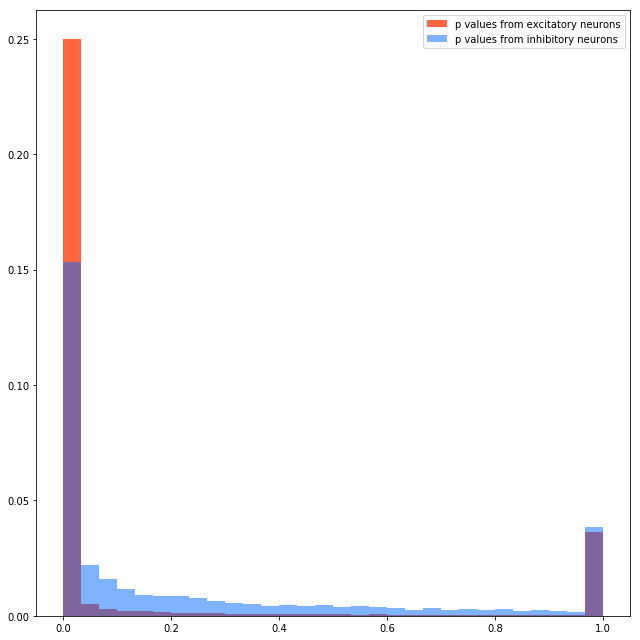

In [139]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [9, 9]

fig, axes = plt.subplots(1,1)



plt.bar(bin_edges[:-1], h_ex, width=bin_width, align='edge', color=[1, 0.2, 0], alpha=0.75, label='p values from excitatory neurons')
plt.bar(bin_edges[:-1], h_in, width=bin_width, align='edge', color=[0, 0.4, 1], alpha=0.5, label='p values from inhibitory neurons')

x_for_pdf = np.arange(np.min(bin_edges), np.max(bin_edges), bin_width/10.0)
#normal_within = scipy.stats.norm(loc=np.mean(SED_within), scale = np.std(SED_within))
#plt.plot(x_for_pdf, normal_within.pdf(x_for_pdf)*bin_width, '-k', label = 'Normal pdf fit to data')
#normal_between = scipy.stats.norm(loc=np.mean(SED_between), scale = np.std(SED_between))
#plt.plot(x_for_pdf, normal_between.pdf(x_for_pdf)*bin_width, '-k', label = 'Normal pdf fit to data')

#axes.set_ylim([0, 1])
    
#axes.set_xlabel('column mean', fontsize = 15)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#this is a two-sided test, and thus symmetric, i.e. mannwhitneyu(x1, x2) = mannwhitneyu(x2, x1)
#not sure why we have enriched values at 1
#we still see this when leaving out the BH procedure

In [149]:
#how much overlap do we have between the sets of significant genes 
#from excitatory and inhibitory neurons?

alpha = 0.05
sig_ex = np.logical_and(corr_pval_ex <= alpha, np.logical_not(np.isnan(corr_pval_ex)))
sig_in = np.logical_and(corr_pval_in <= alpha, np.logical_not(np.isnan(corr_pval_in)))
overlap = np.logical_and(np.equal(sig_ex, sig_in), np.equal(sig_ex, 1))
sum_sig_ex = np.sum(sig_ex)
sum_sig_in = np.sum(sig_in)
sum_overlap = np.sum(overlap)

print('Total number of genes = %d'%len(sig_ex))

print('Number of significant genes from excitatory neurons = %d'%sum_sig_ex)
print('Number of significant genes from inhibitory neurons = %d'%sum_sig_in)
print('Number of overlapping genes = %d'%sum_overlap)

Total number of genes = 45768
Number of significant genes from excitatory neurons = 11582
Number of significant genes from inhibitory neurons = 7567
Number of overlapping genes = 6052


/Users/cstoneki/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less_equal
  """
/Users/cstoneki/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


In [143]:
#is the overlap between excitatory and inhibitory gene sets significant?
import scipy.stats
p_binom = scipy.stats.binom_test(sum_overlap, sum_sig_in, float(sum_sig_ex)/len(sig_ex))
print('P value for overlap between excitatory and inhibitory significant genes = %.5f'%p_binom)

P value for overlap between excitatory and inhibitory significant genes = 0.00000


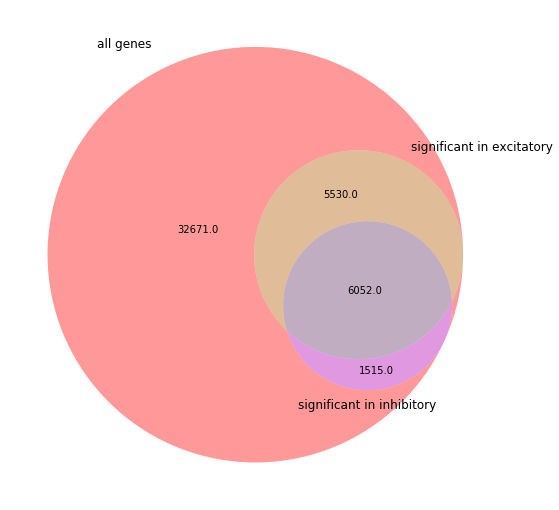

In [147]:
from matplotlib_venn import venn3
base = np.ones(len(sig_ex))
not_base = np.zeros(len(sig_ex))
not_sig_ex = np.logical_not(sig_ex)
not_sig_in = np.logical_not(sig_in)
Abc = np.sum(base*not_sig_ex*not_sig_in)
ABc = np.sum(base*sig_ex*not_sig_in)
AbC = np.sum(base*not_sig_ex*sig_in)
ABC = np.sum(base*sig_ex*sig_in)
#order (Abc, aBc, ABc, abC, AbC, aBC, ABC)
venn3(subsets = (Abc, 0, ABc, 0, AbC, 0, ABC), set_labels = ['all genes', 'significant in excitatory', 'significant in inhibitory'])
plt.show()

In [ ]:
#note that the numbers can be confusing! They don't refer to the total area of the circle
#but to the area of their particular subset
#e.g. the red circle has size equal to the full gene set (45k)
#but the number displayed in it is the number of non-significant genes

In [157]:
#save p values for GO analysis in R
output_folder = '/Users/cstoneki/Documents/data/gene_expression/diff_expr_01/'
pd.DataFrame(data=corr_pval_ex).to_csv(output_folder+'adj_p_val_ex_01.csv')
pd.DataFrame(data=corr_pval_in).to_csv(output_folder+'adj_p_val_in_01.csv')

vis_gene_names = pd.read_csv(main_folder + '/' + vis_subfolder + '/' + vis_gene_names_file)
pd.DataFrame(data=vis_gene_names['gene_symbol']).to_csv(output_folder+'gene_names.csv')

### misc unused things

In [ ]:
def relative_rank(x1, x2):
    x2.sort()
    rr = np.ones(len(x1))
    n2 = float(len(x2))
    for m, u in enumerate(x1):
        rr[m] = bin_search(u, x2)/n2
    return rr

In [200]:
def bin_search(x, arr):

    if (arr[-1] < x):
        return len(arr)
    if(arr[0] > x):
        return 0
    
    left_pos = 0
    right_pos = len(arr)
    
    while (left_pos < right_pos): #<=
        m = int(left_pos + (right_pos - left_pos) / 2.0); 
  
        if (arr[m] < x):
            left_pos = m + 1; 
  
        else:
            right_pos = m - 1; 
    
    return left_pos

In [209]:
from scipy.stats import binom
def binomial_p(x1, x2):
    x2.sort()
    p_vals  = np.zeros(len(x1))
    n_total = float(len(x2))
    for m, u in enumerate(x1):
        n_strictly_smaller = bin_search(u, x2)
        p_vals[m] = binom.cdf(n_strictly_smaller, n_total + 1, 0.5)
    return p_vals
